# Семинар 2

In [112]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import STL, MSTL

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError



plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

# https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html

## STL-декомпозиция

In [85]:
from statsmodels.datasets import elec_equip as ds

elec_equip = ds.load().data.iloc[:, 0]
elec_equip.name = "Electrical equipment production"

elec_equip.head()



DATE
1995-01-01    66.19
1995-02-01    65.15
1995-03-01    74.48
1995-04-01    71.26
1995-05-01    67.63
Name: Electrical equipment production, dtype: float64

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Electrical equipment production'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

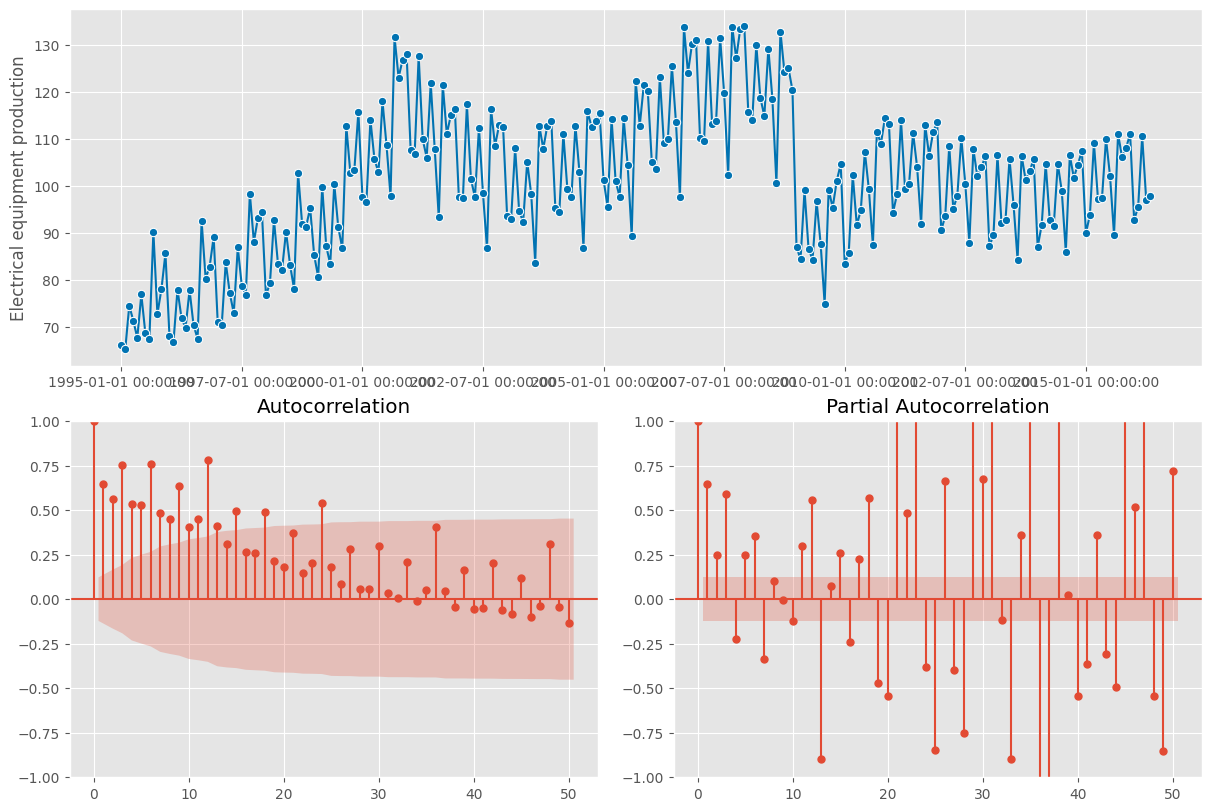

In [86]:
plot_correlations(elec_equip, lags = 50 )

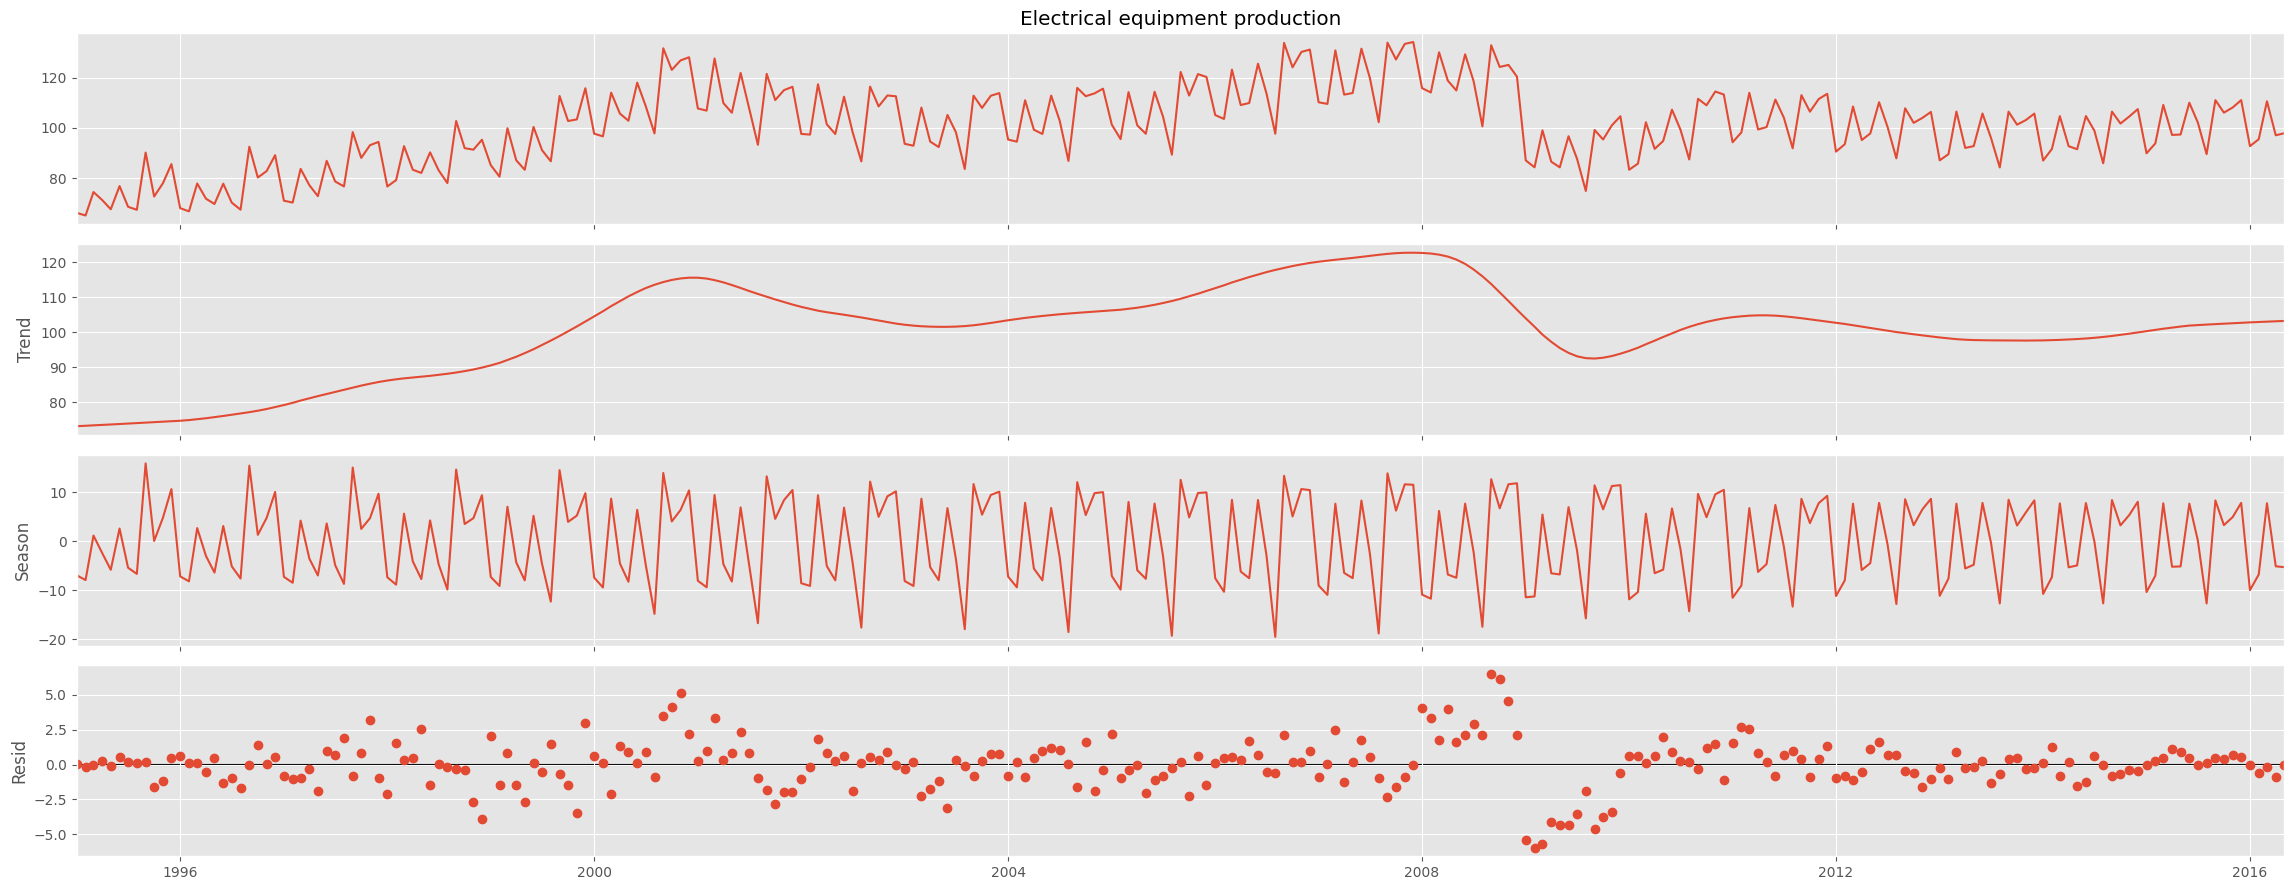

In [89]:
res = STL(elec_equip, period=12).fit()
ax = res.plot()

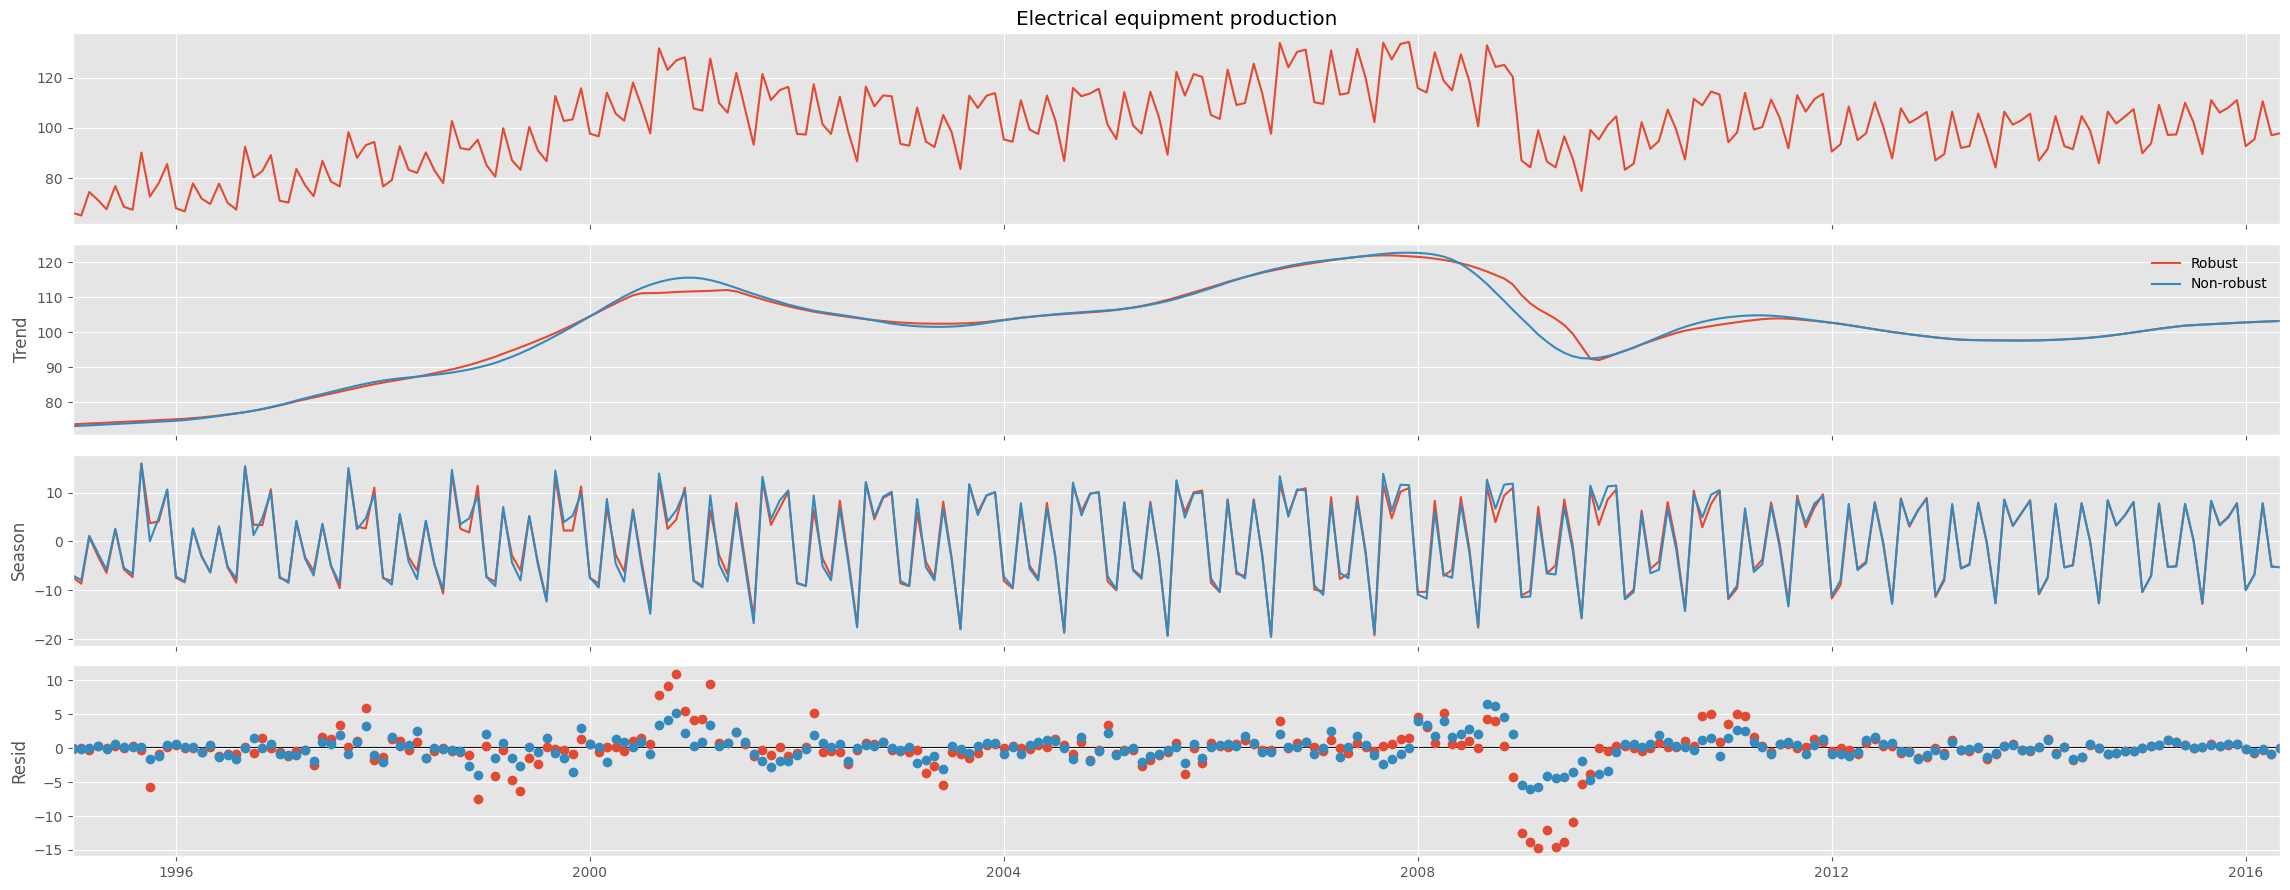

In [90]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

stl = STL(elec_equip, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(elec_equip, period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

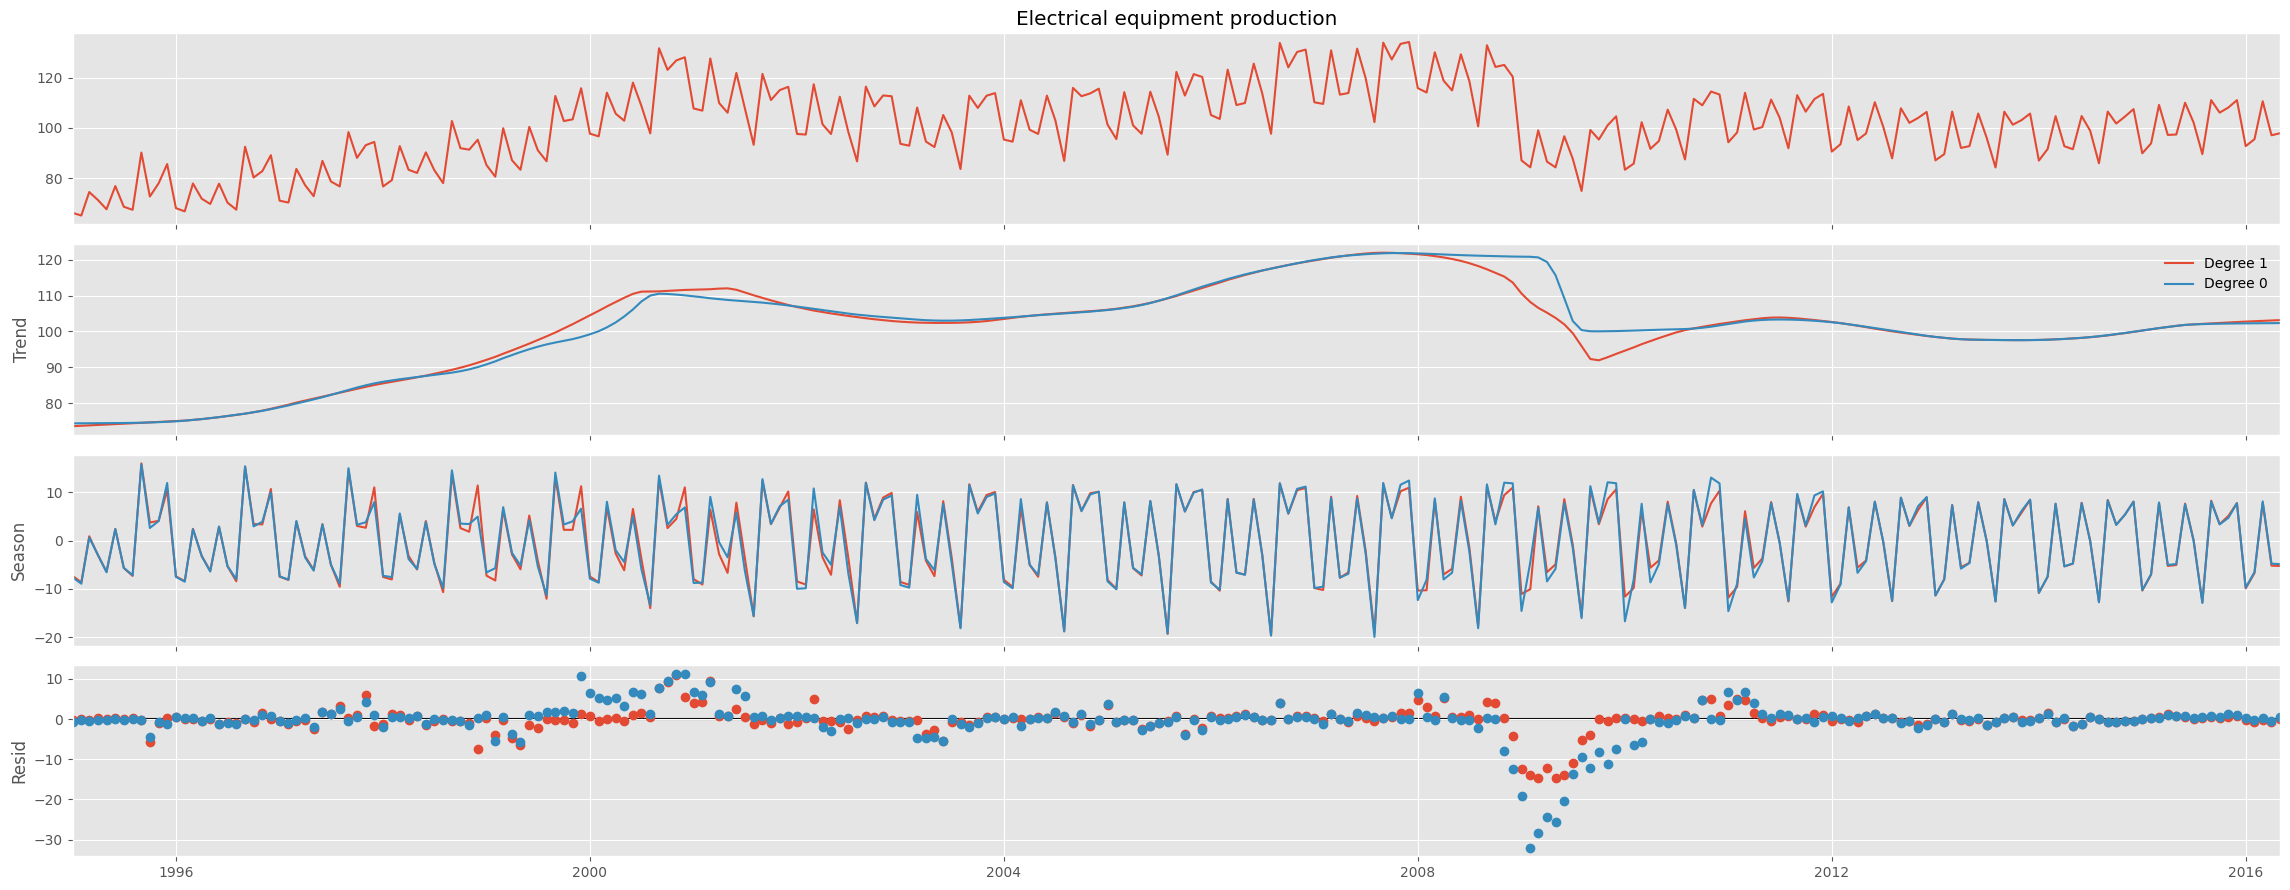

In [94]:
stl = STL(
    elec_equip, period=12, seasonal_deg=1, trend_deg=0, low_pass_deg=0, robust=True
)
res_deg_0 = stl.fit()
fig = res_robust.plot()
add_stl_plot(fig, res_deg_0, ["Degree 1", "Degree 0"])

In [97]:
res.seasonal

1995-01-01   -6.956856
1995-02-01   -7.921252
1995-03-01    1.147406
1995-04-01   -2.449154
1995-05-01   -5.824276
                ...   
2016-01-01   -9.979871
2016-02-01   -6.779681
2016-03-01    7.730177
2016-04-01   -5.113745
2016-05-01   -5.294986
Name: season, Length: 257, dtype: float64

In [69]:
res.trend

1959-06-30    0.718853
1959-09-30    0.718530
1959-12-31    0.719478
1960-03-31    0.721390
1960-06-30    0.724616
                ...   
2008-09-30    0.686698
2008-12-31    0.686396
2009-03-31    0.686313
2009-06-30    0.686252
2009-09-30    0.686246
Freq: Q-DEC, Name: trend, Length: 202, dtype: float64

## MSTL

In [98]:
t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
y = trend + daily_seasonality + weekly_seasonality + np.random.randn(len(t))
ts = pd.date_range(start="2020-01-01", freq="H", periods=len(t))
df = pd.DataFrame(data=y, index=ts, columns=["y"])

df.head()

y
2020-01-01 00:00:00  0.591197
2020-01-01 01:00:00  3.134321
2020-01-01 02:00:00  5.243995
2020-01-01 03:00:00  7.221070
2020-01-01 04:00:00  8.304148

<Axes: >

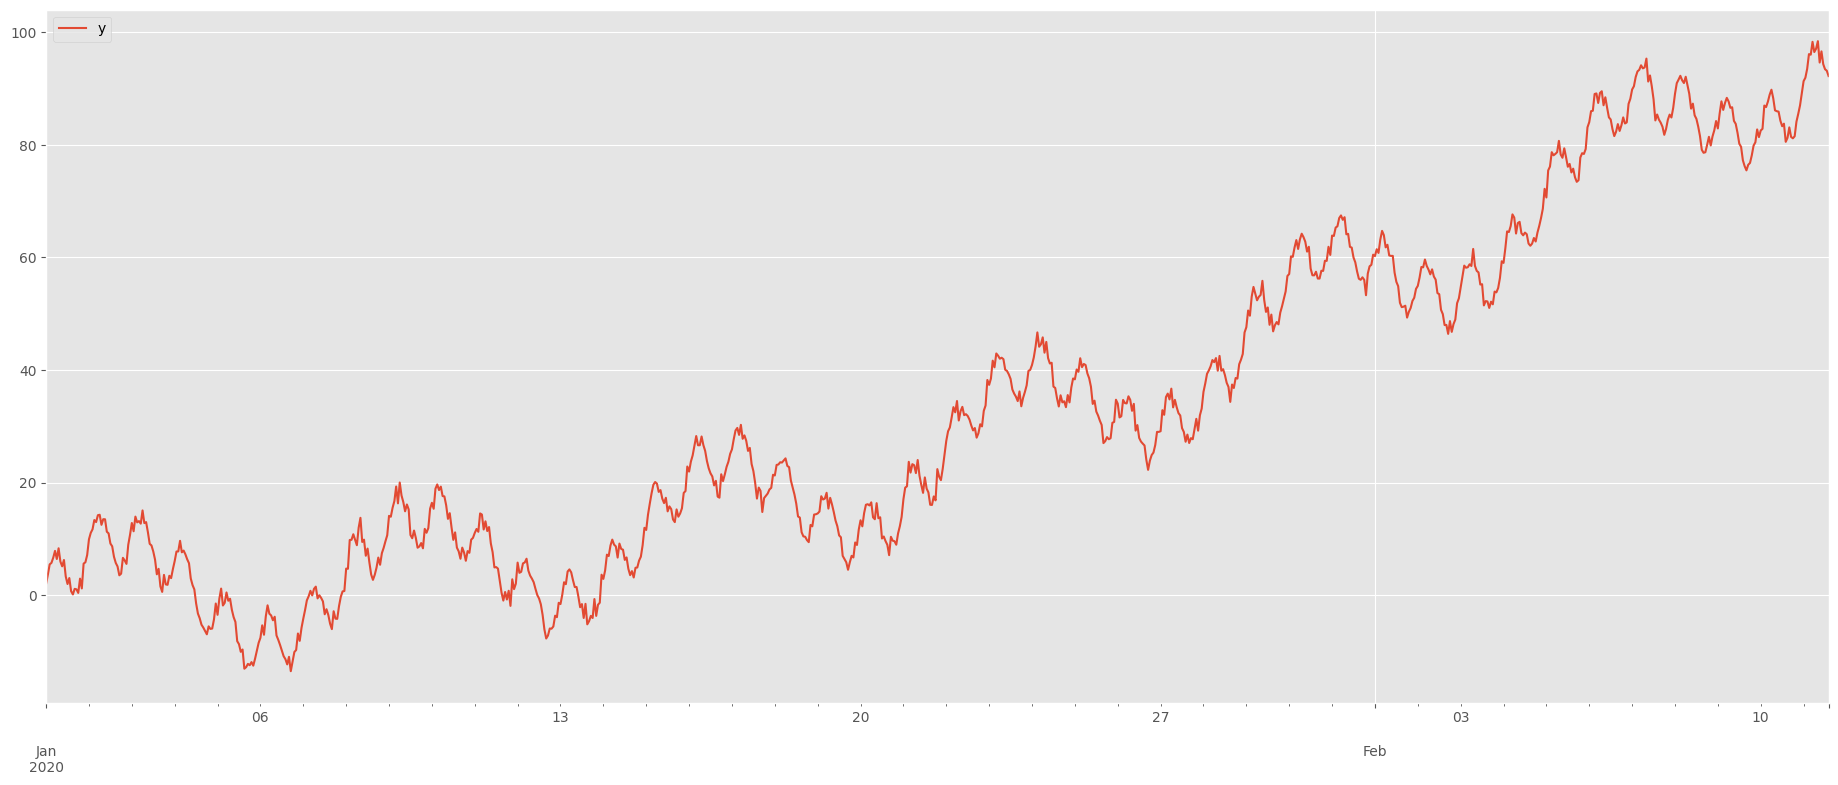

In [72]:
df.plot()

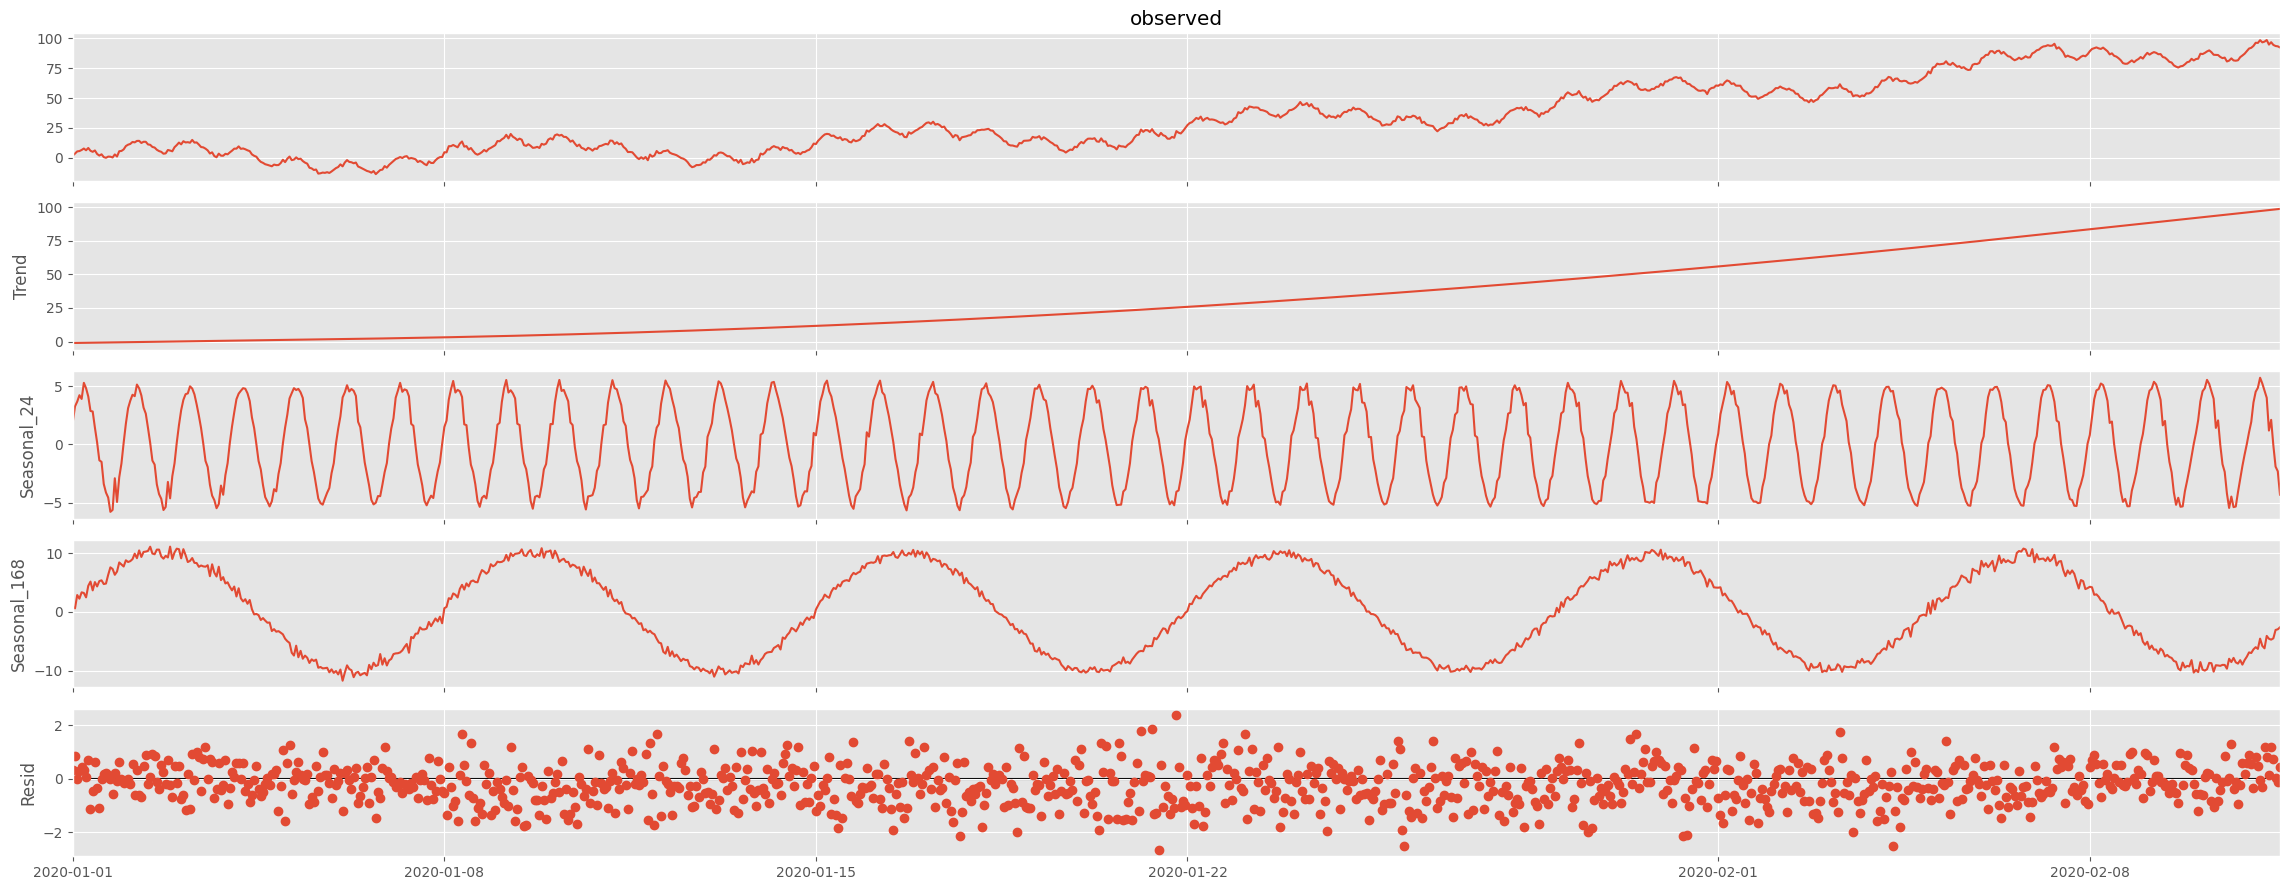

In [74]:
mstl = MSTL(df["y"], periods=[24, 24 * 7])
res = mstl.fit()
res.plot(fig);

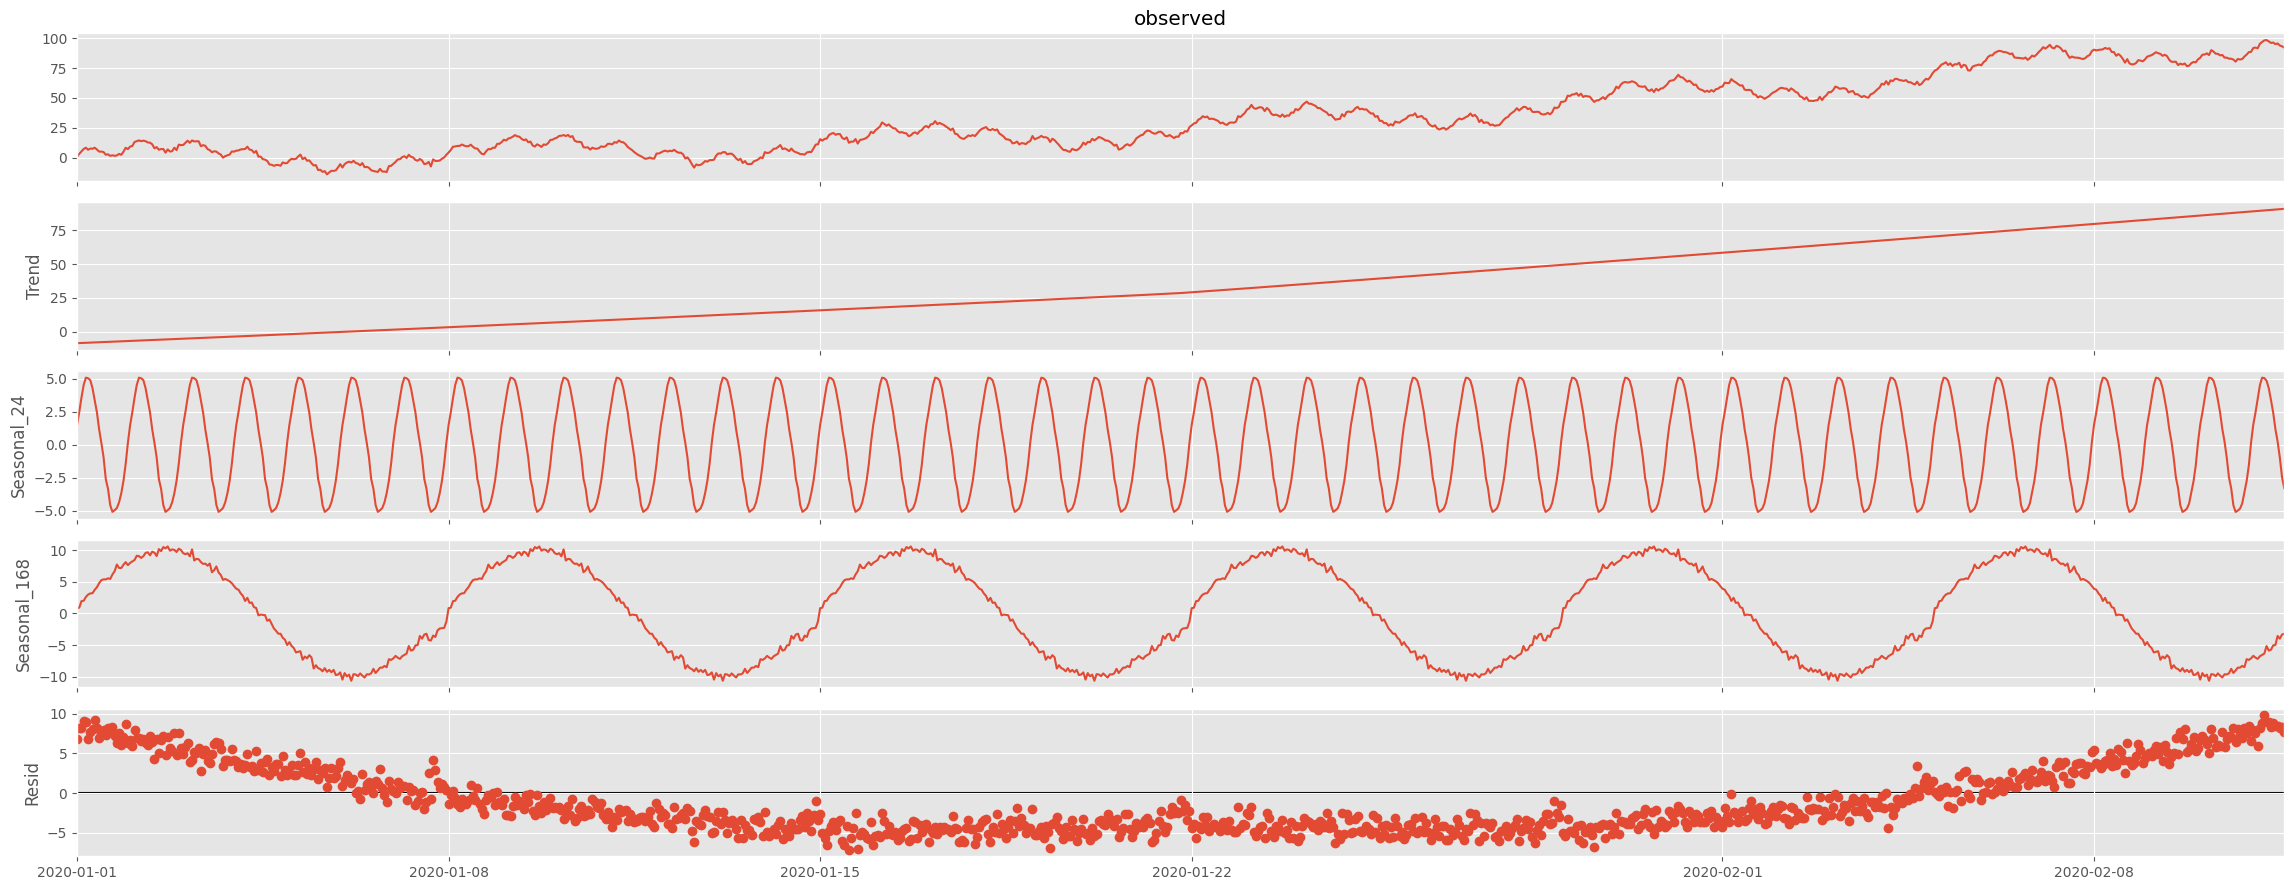

In [99]:
mstl = MSTL(
    df,
    periods=[24, 24 * 7],  # The periods and windows must be the same length and will correspond to one another.
    windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
    iterate=3,
    stl_kwargs={
                "trend":1001, # Setting this large will force the trend to be smoother.
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
)
res = mstl.fit()
ax = res.plot()

Date  Period  OperationalLessIndustrial   Industrial
0  37257       1                3535.867064  1086.132936
1  37257       2                3383.499028  1088.500972
2  37257       3                3655.527552  1084.472448
3  37257       4                3510.446636  1085.553364
4  37257       5                3294.697156  1081.302844

<Axes: xlabel='ds'>

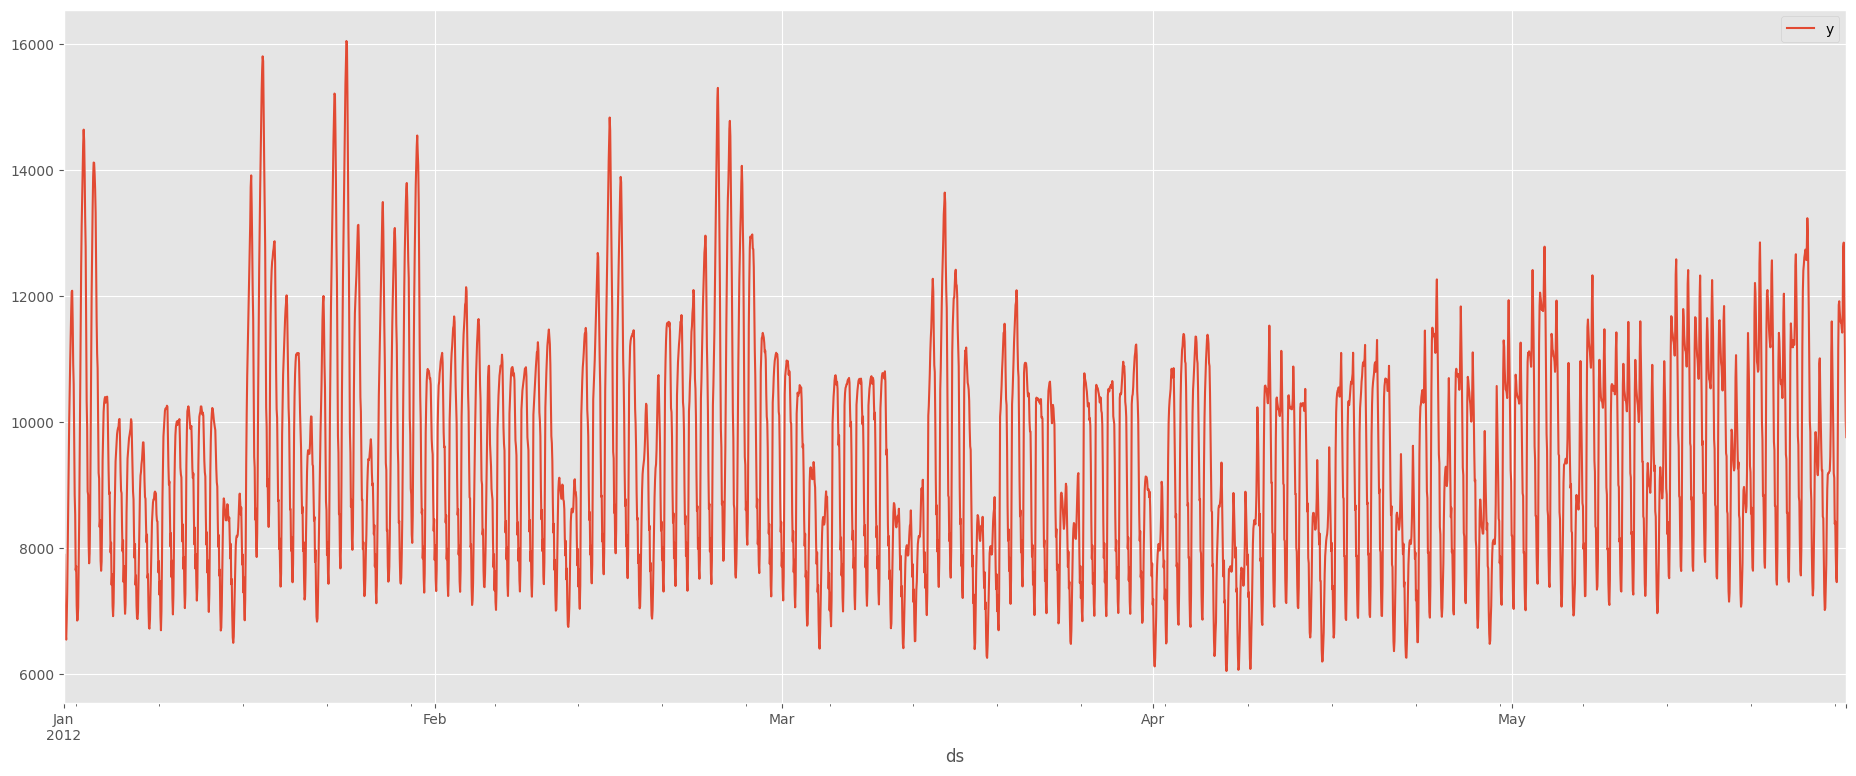

In [109]:
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.head()

df["Date"] = df["Date"].apply(lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days"))
df["ds"] = df["Date"] + pd.to_timedelta((df["Period"]-1)*30, unit="m")

timeseries = df[["ds", "OperationalLessIndustrial"]]
timeseries.columns = ["ds", "y"] # Rename to OperationalLessIndustrial to y for simplicity.

# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
mask = (timeseries["ds"] >= start_date) & (timeseries["ds"] < end_date)
timeseries = timeseries[mask]

# Resample to hourly
timeseries = timeseries.set_index("ds").resample("H").sum()
timeseries.plot()

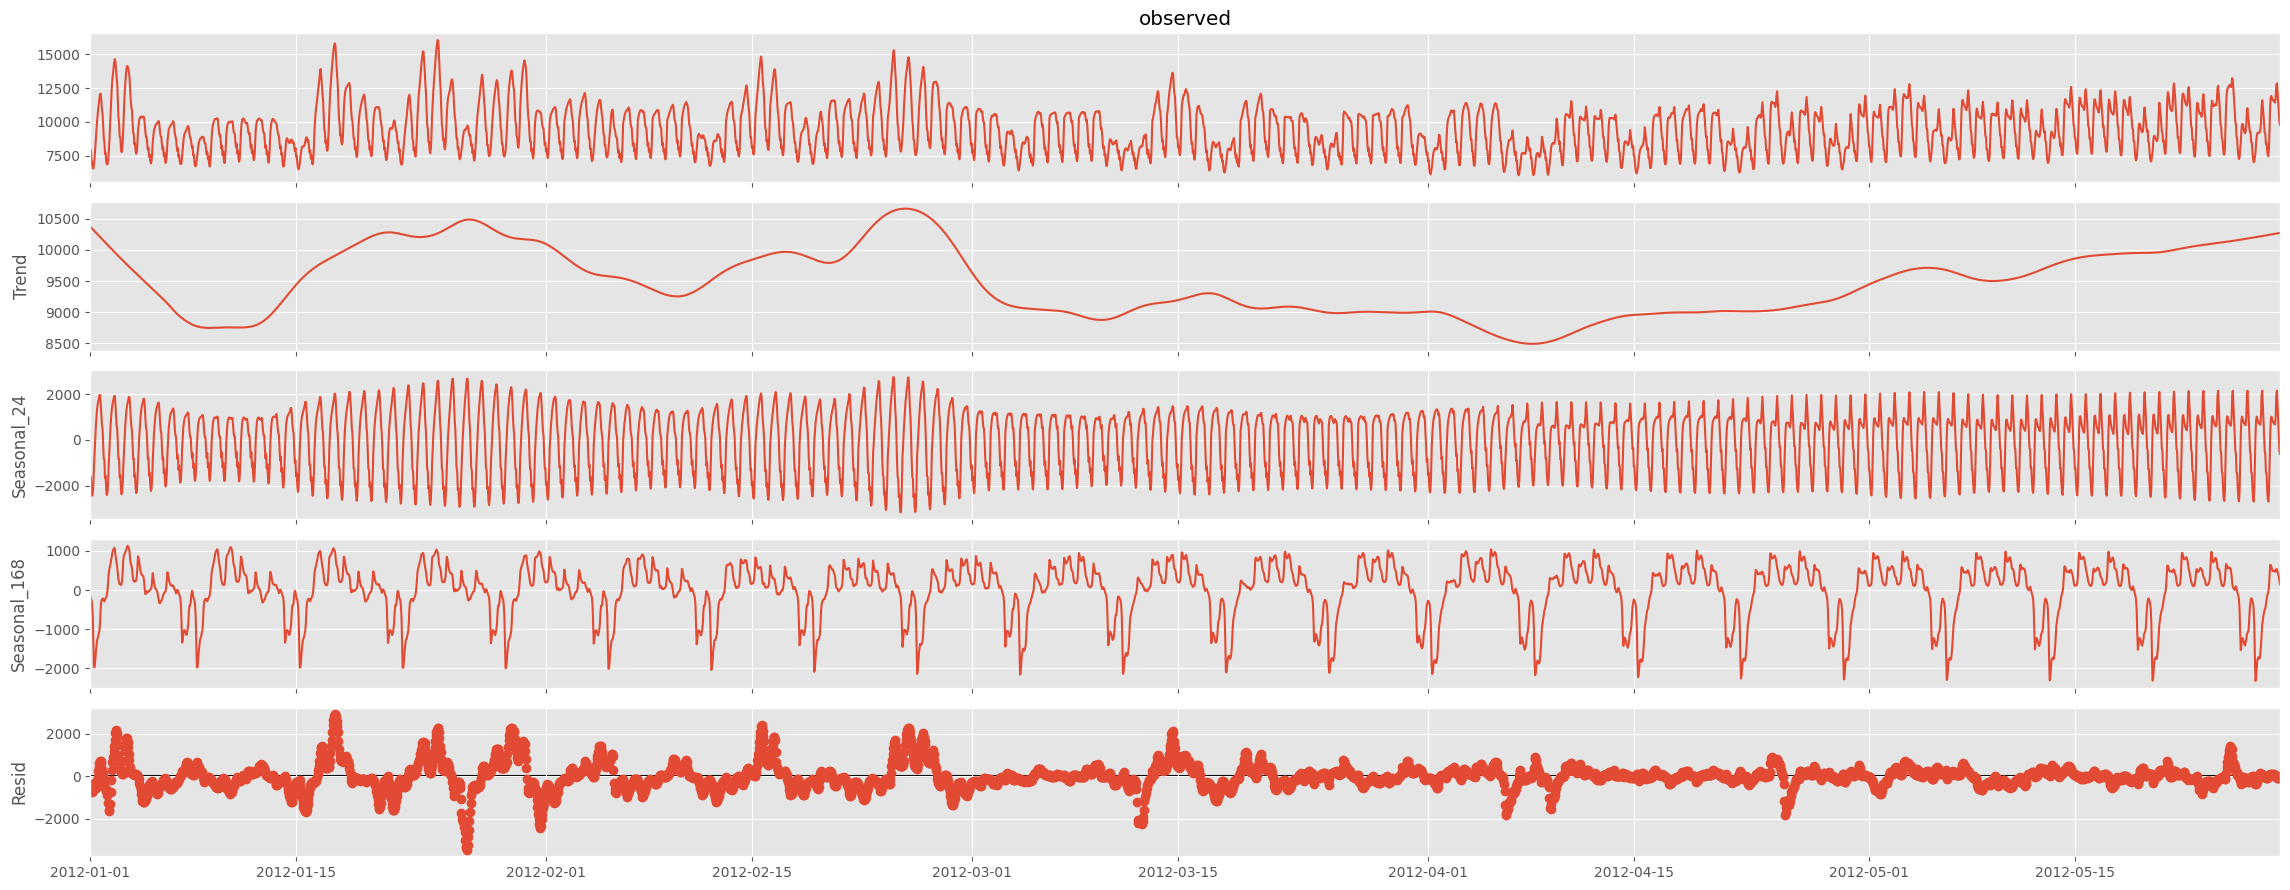

In [110]:
mstl = MSTL(timeseries["y"], periods=[24, 24 * 7], iterate=3, stl_kwargs={"seasonal_deg": 0, #Эти параметры установлены только для того
                                                                          "inner_iter": 2, #чтобы соответствовать исходной статье
                                                                          "outer_iter": 0})
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()

Дневной паттерн вполне логичный. Днём включаем кондиционер. На недельном паттерне по выходным потребление ниже.

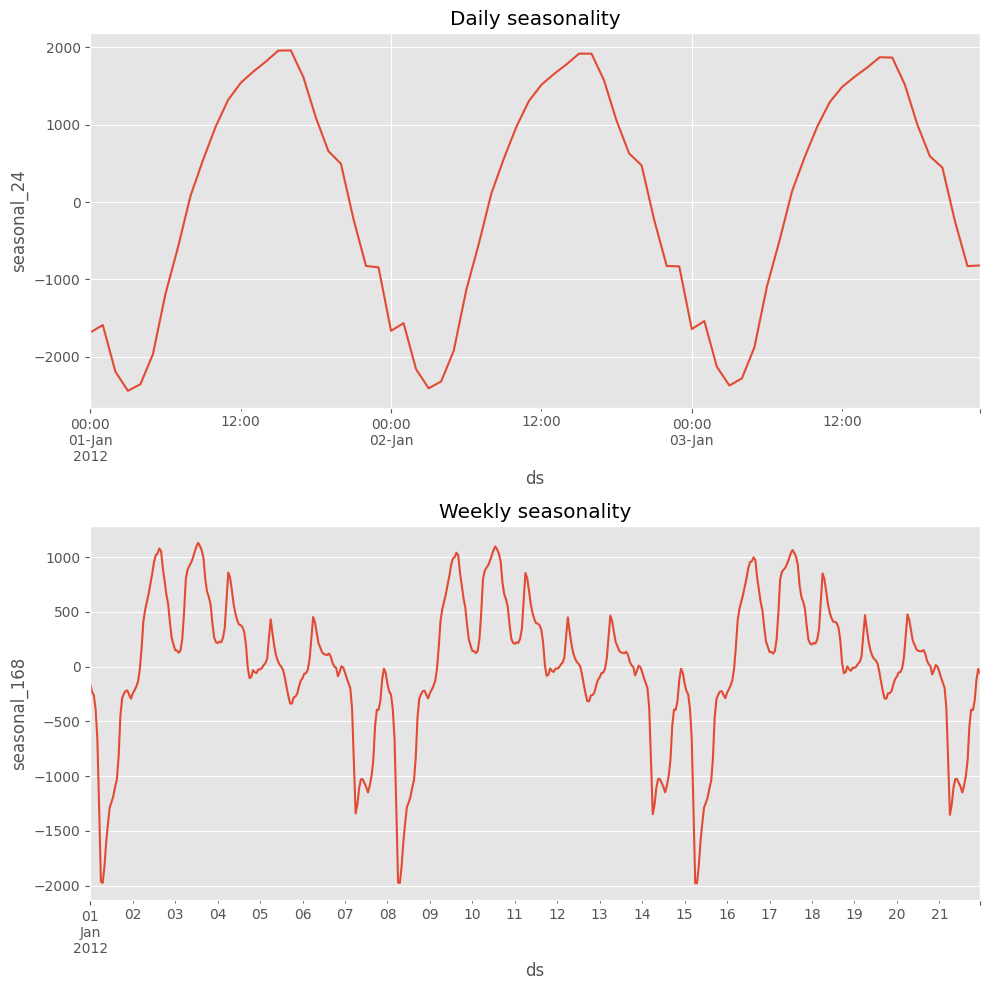

In [111]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
res.seasonal["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()

А теперь видим, что дневной паттерн поменялся. Не забываем, что в южном полушарии сезоны наоборот. Вечером теперь необходимо всключать отопление и свет. На выходных потребление также понижается.

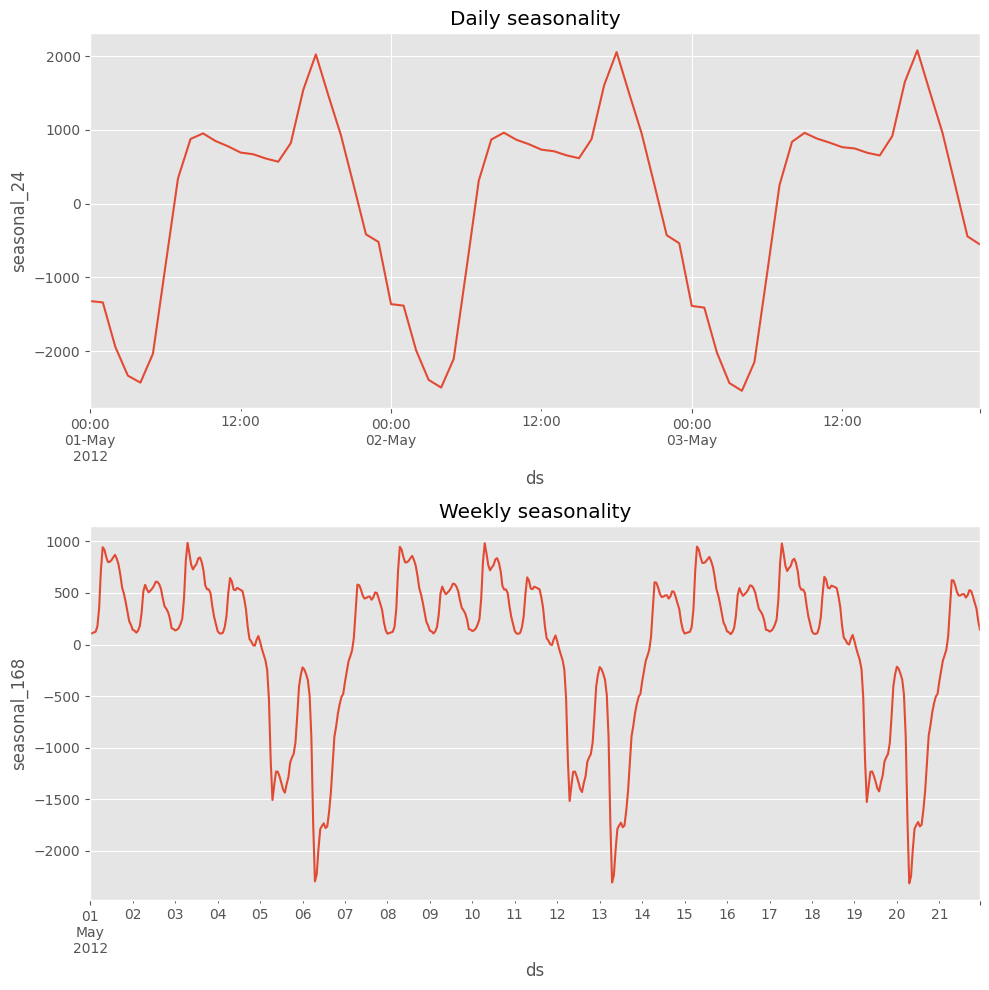

In [113]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
mask = res.seasonal.index.month==5
res.seasonal[mask]["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal[mask]["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()

## Обработка пропусков

Обработка пропусков во временных рядах связана всё с той же проблемой: данные связаны по времени. Это с одной стороны помогает, а с другой стороны мешает. Разберём некоторые наиболее значимые кейсы.

#### Смотрим на контекст!

Часто само происхождение данных или непосредственно задача диктует правила обработки пропусков. Рассмотрим пример ниже. Вам представлен график недельных цен на некоторый вид химического сырья в некотором регионе мира. В данном случае вполне логично интерпретировать пропуски как "цена не изменилась", поэтому можно заполнить пропуски просто последним доступным значением. С одной стороны это, конечно, снижает дисперсию данных, но при этом он обоснован.

In [114]:
flat = pd.read_csv('data/sem_2/weekly_flat.csv', index_col=0)
flat.index = pd.to_datetime(flat.index)

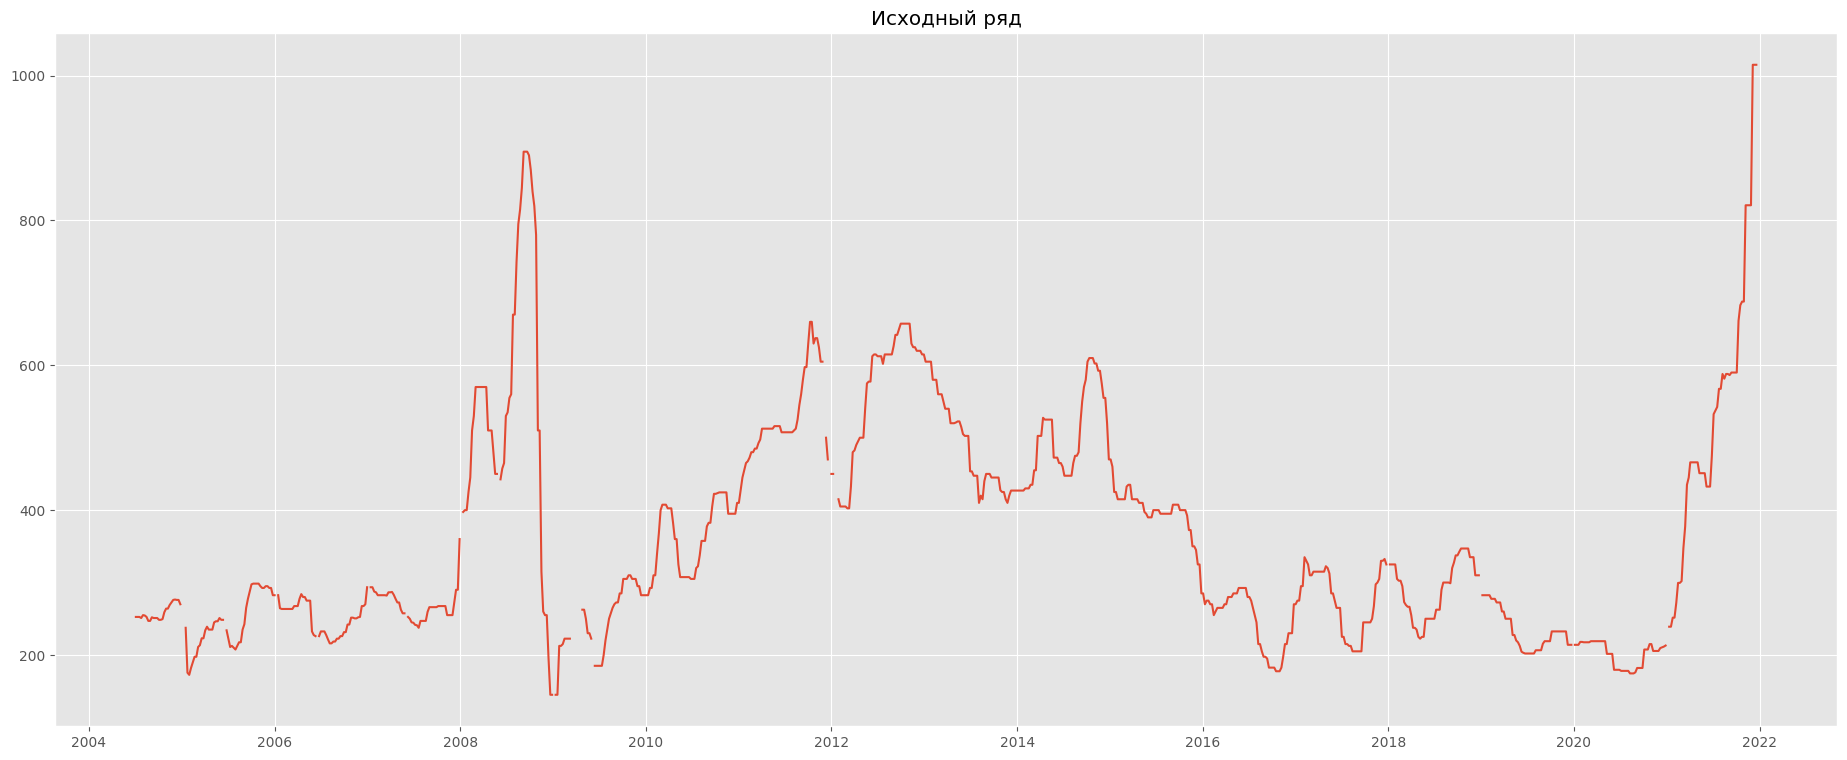

In [115]:

plt.plot(flat)
plt.title('Исходный ряд');

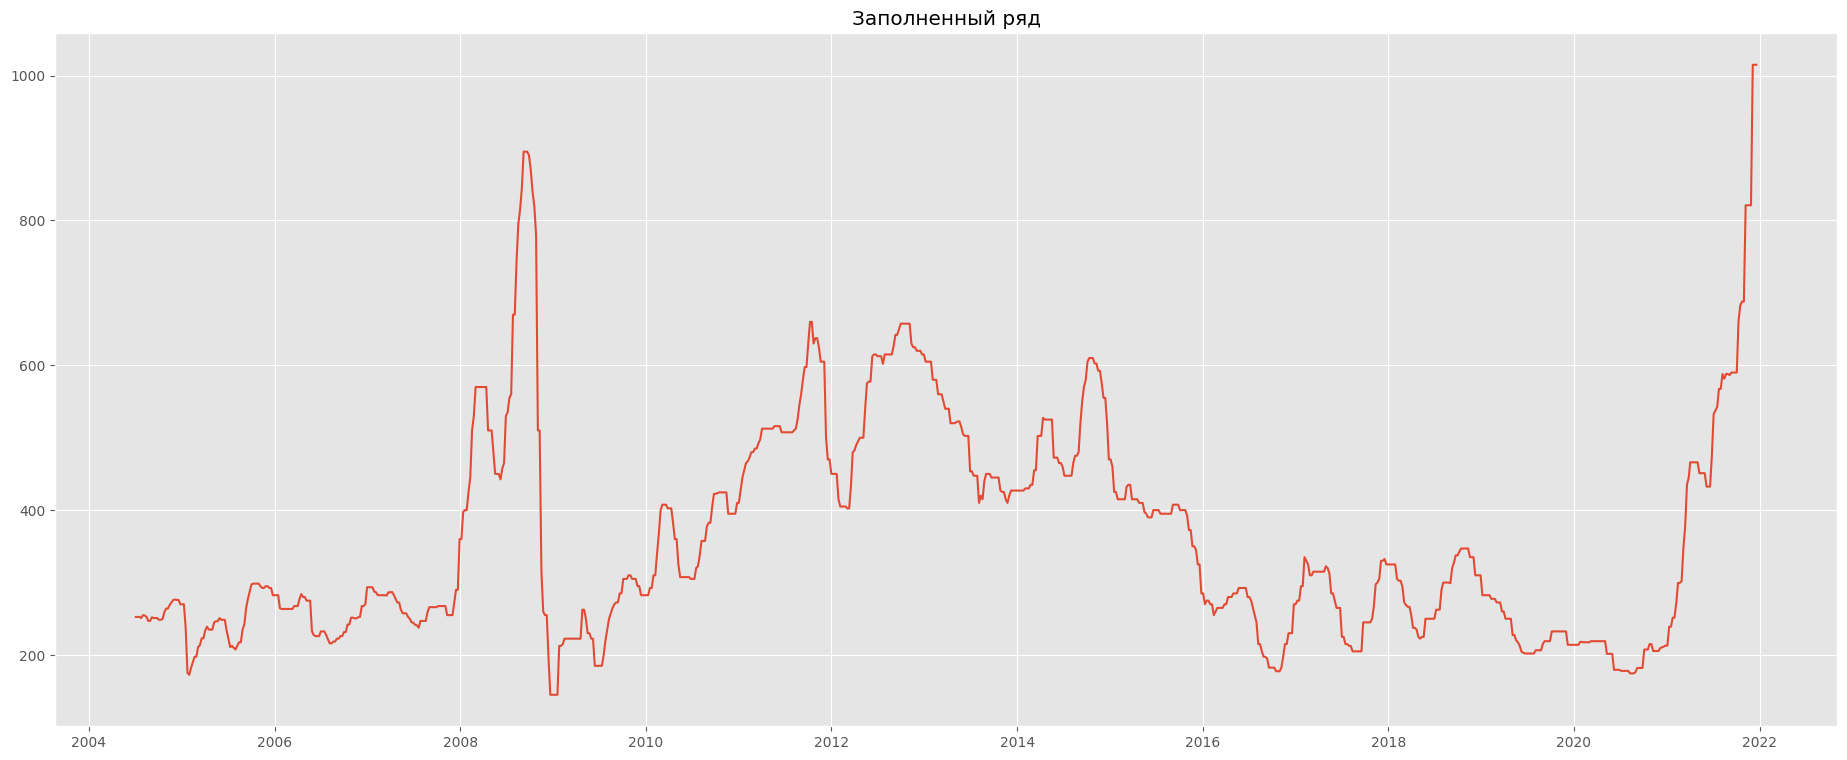

In [116]:

plt.plot(flat.ffill())
plt.title('Заполненный ряд');

#### Смотрим на структуру данных!

Любые паттерны данных и их структура могут помочь в заполнении пропусков. Во-первых, если в данных есть тренд.

In [118]:
macro = sm.datasets.macrodata.load_pandas().data

#Преобразуем данные из колонок в индекс. В данном случае проще всего было сгенерировать самим последовательность кварталов, чтобы не мучаться с конвертацией столбцов
macro.index = pd.date_range(start = '01.01.1959', periods = len(macro), freq='Q')
display(macro)
macro = macro.drop(columns = ['year', 'quarter'])

mask = np.random.binomial(1, 0.2, size=len(macro)) > 0 
gdp_true = macro.realgdp.copy()
gdp_nan = gdp_true.copy()
gdp_nan[mask] = np.nan

year  quarter    realgdp  realcons   realinv  realgovt  realdpi  \
1959-03-31  1959.0      1.0   2710.349    1707.4   286.898   470.045   1886.9   
1959-06-30  1959.0      2.0   2778.801    1733.7   310.859   481.301   1919.7   
1959-09-30  1959.0      3.0   2775.488    1751.8   289.226   491.260   1916.4   
1959-12-31  1959.0      4.0   2785.204    1753.7   299.356   484.052   1931.3   
1960-03-31  1960.0      1.0   2847.699    1770.5   331.722   462.199   1955.5   
...            ...      ...        ...       ...       ...       ...      ...   
2008-09-30  2008.0      3.0  13324.600    9267.7  1990.693   991.551   9838.3   
2008-12-31  2008.0      4.0  13141.920    9195.3  1857.661  1007.273   9920.4   
2009-03-31  2009.0      1.0  12925.410    9209.2  1558.494   996.287   9926.4   
2009-06-30  2009.0      2.0  12901.504    9189.0  1456.678  1023.528  10077.5   
2009-09-30  2009.0      3.0  12990.341    9256.0  1486.398  1044.088  10040.6   

                cpi      m1  tbilrate  unemp      pop  infl  realint  
1959-03-31   28.980   139.7      2.82    5.8  177.146  0.00     0.00  
1959-06-30   29.150   141.7      3.08    5.1  177.830  2.34     0.74  
1959-09-30   29.350   140.5      3.82    5.3  178.657  2.74     1.09  
1959-12-31   29.370   140.0      4.33    5.6  179.386  0.27     4.06  
1960-03-31   29.540   139.6      3.50    5.2  180.007  2.31     1.19  
...             ...     ...       ...    ...      ...   ...      ...  
2008-09-30  216.889  1474.7      1.17    6.0  305.270 -3.16     4.33  
2008-12-31  212.174  1576.5      0.12    6.9  305.952 -8.79     8.91  
2009-03-31  212.671  1592.8      0.22    8.1  306.547  0.94    -0.71  
2009-06-30  214.469  1653.6      0.18    9.2  307.226  3.37    -3.19  
2009-09-30  216.385  1673.9      0.12    9.6  308.013  3.56    -3.44  

[203 rows x 14 columns]

<Axes: >

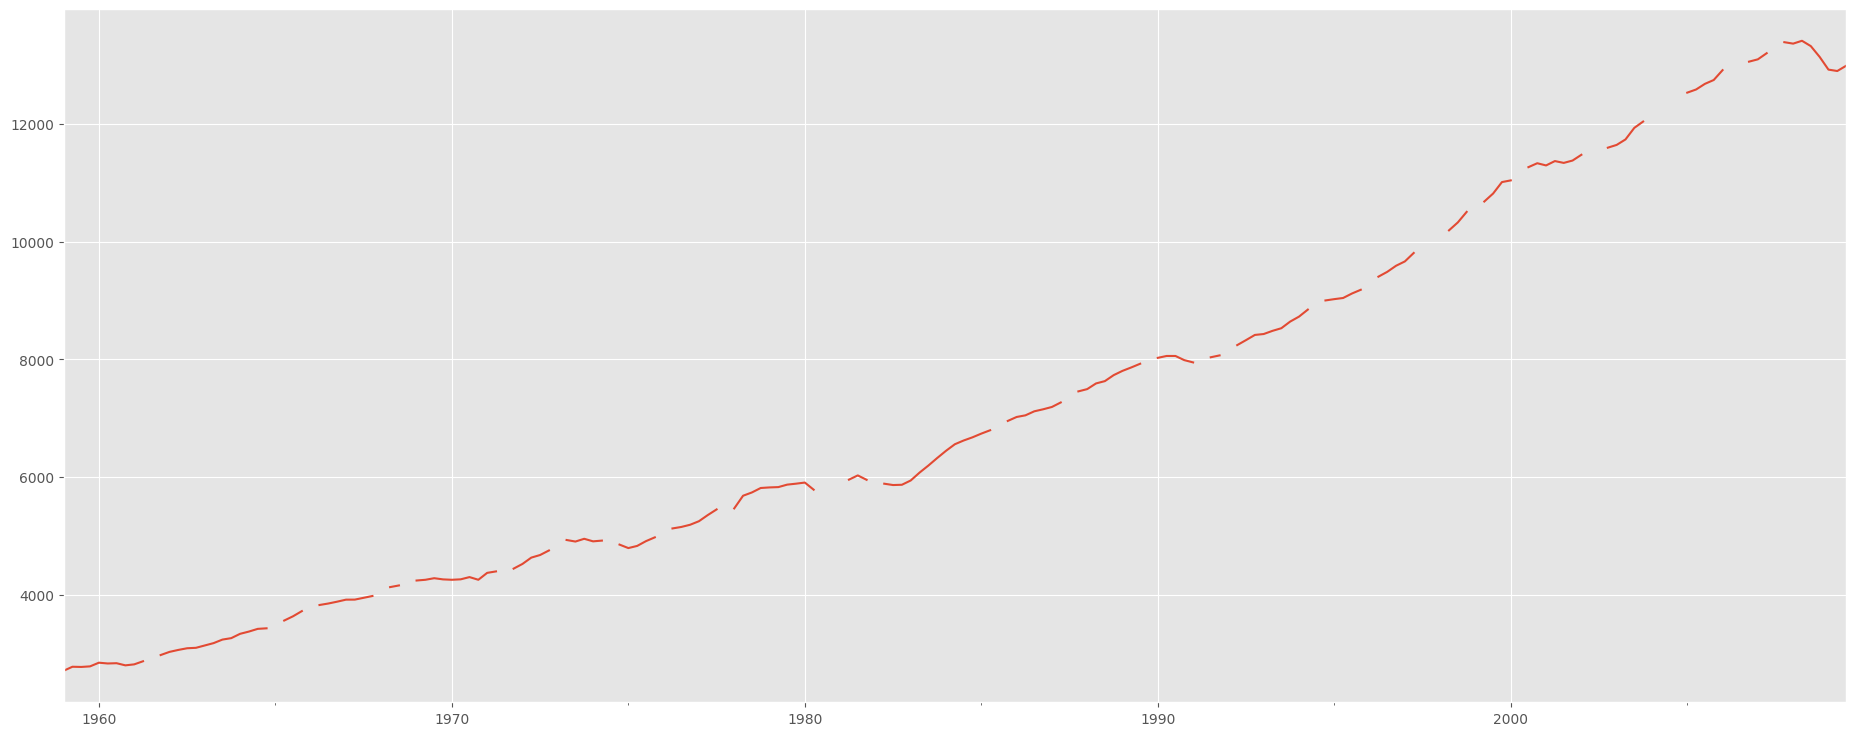

In [119]:
gdp_nan.plot()

<Axes: >

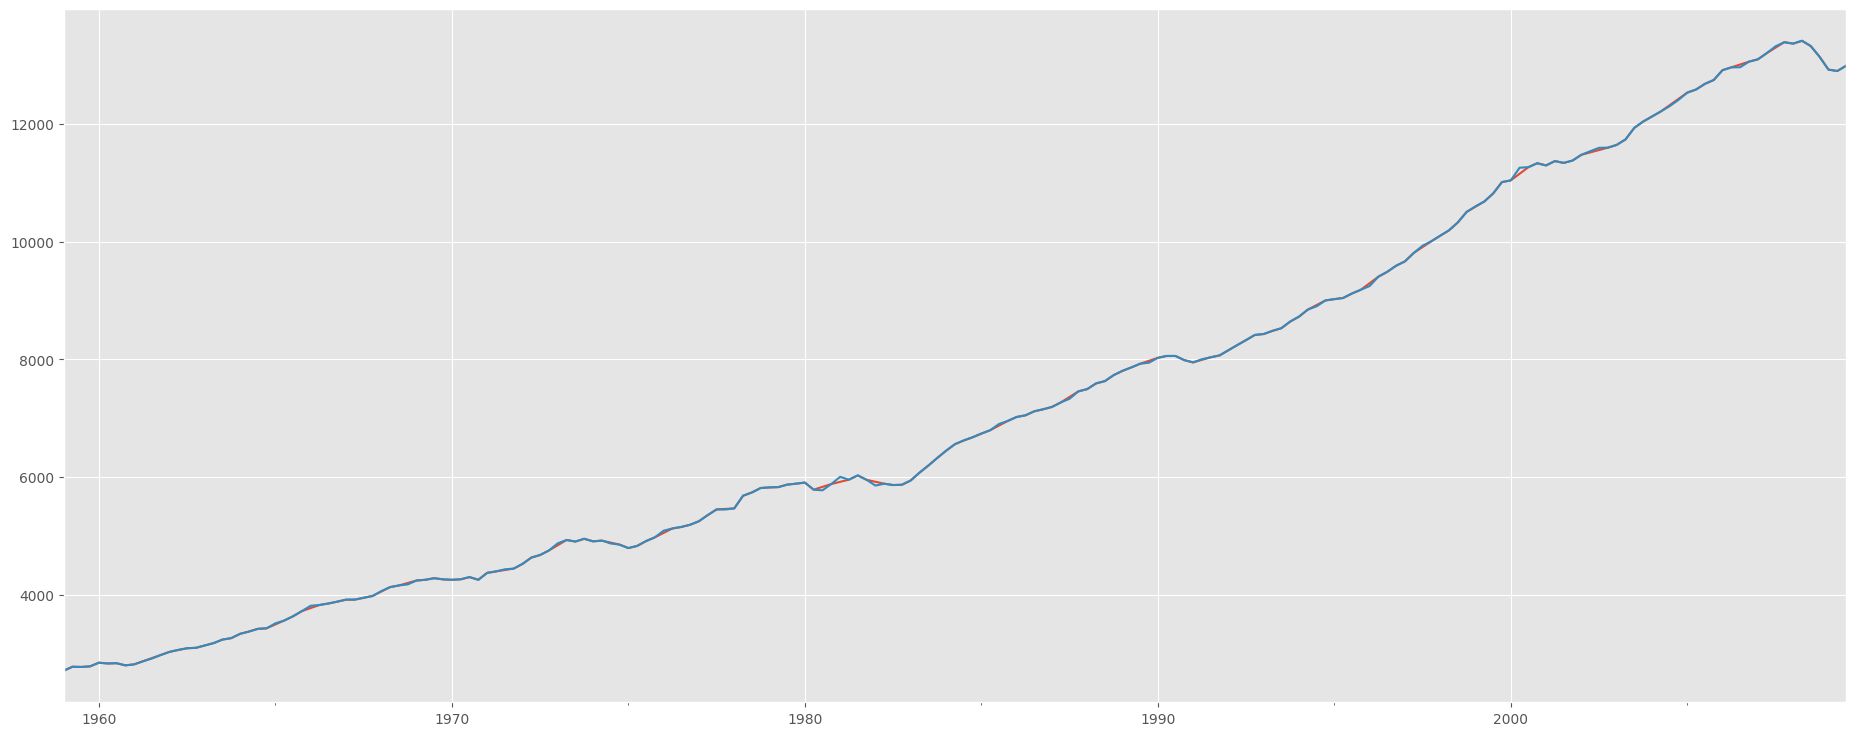

In [120]:
gdp_nan.interpolate(method='linear').plot()
gdp_true.plot()

<Axes: >

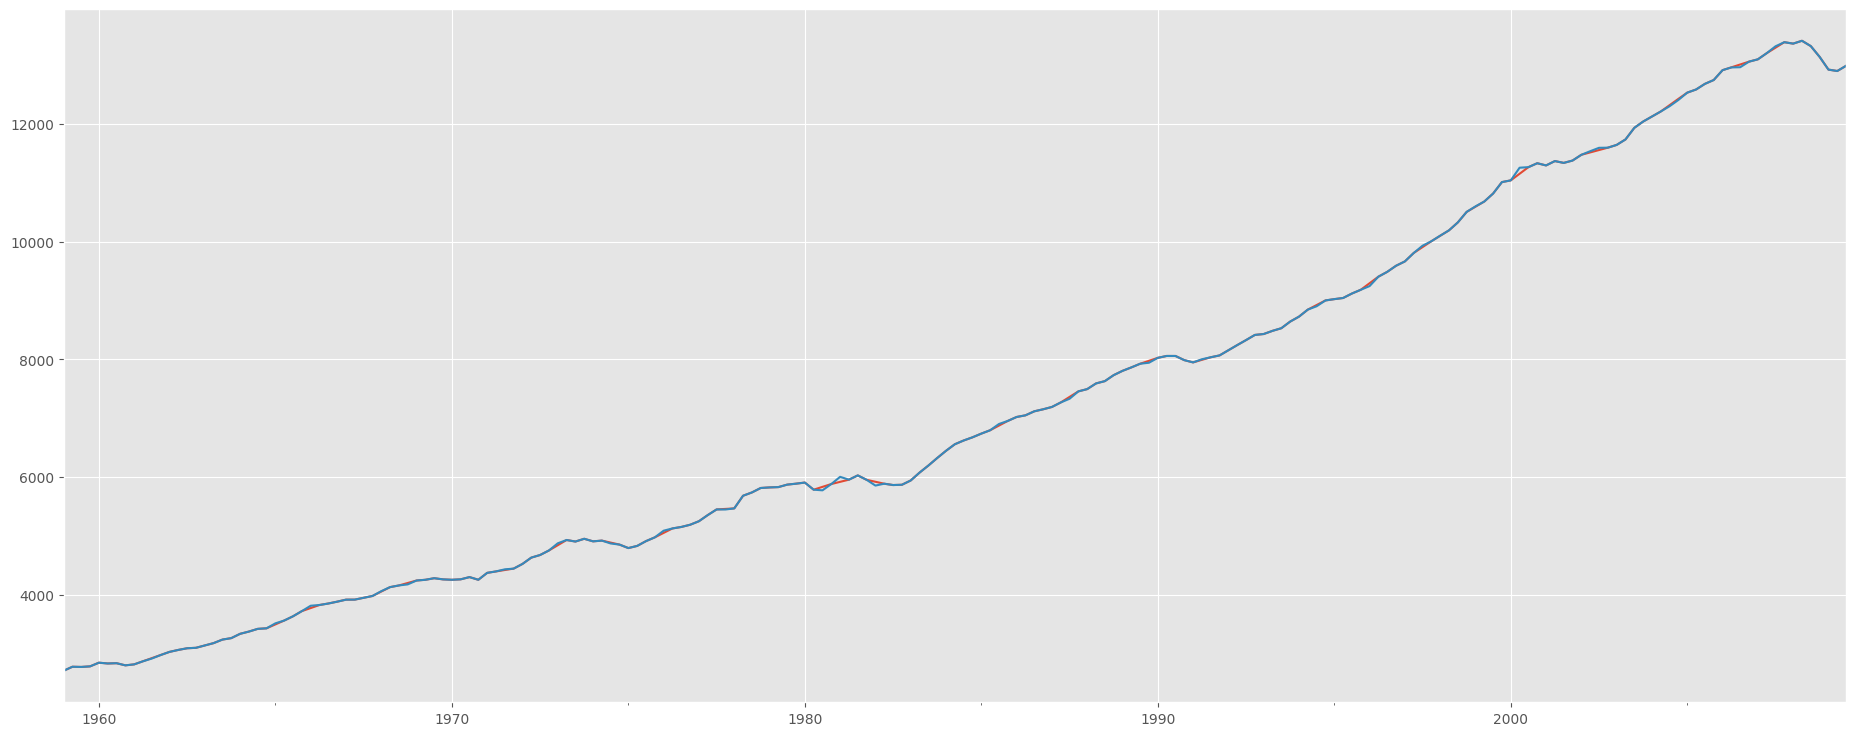

In [121]:
gdp_nan.interpolate(method='time').plot()
gdp_true.plot()

In [122]:
# MAE заполнения
np.abs(gdp_nan.interpolate(method='time') - gdp_true)[mask].mean()

27.68759475696784

## LOWESS

In [123]:


# mask = np.random.binomial(1, 0.1, size=len(data)) > 0 
gdp_true = macro.realgdp.copy()
gdp_nan = gdp_true.copy()
gdp_nan[mask] = np.nan

gdp_nan = gdp_nan.reset_index(drop=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


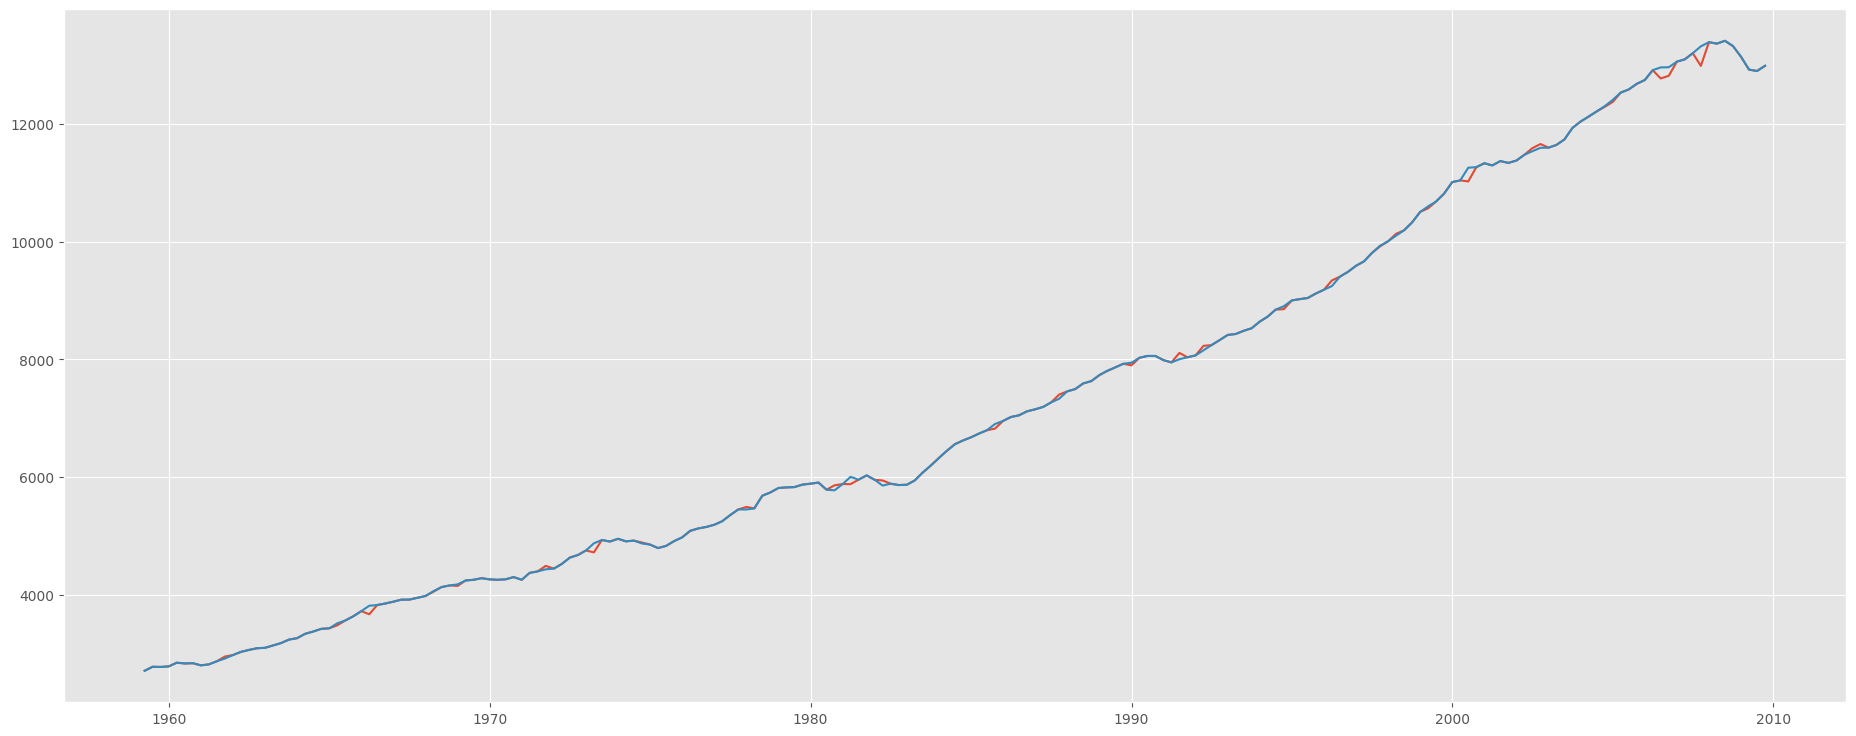

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from moepy import lowess

# Data generation
x = np.array(gdp_nan[~mask].index)
y = gdp_nan[~mask].values

x_pred = np.array(gdp_nan[mask].index)

# Model fitting
lowess_model = lowess.Lowess()
lowess_model.fit(x, y, frac=0.15)

# Model prediction
y_pred = lowess_model.predict(x_pred)
gdp_filled = gdp_nan.copy()
gdp_filled[mask] = y_pred
gdp_filled.index = gdp_true.index

# Plotting
plt.plot(gdp_filled)
plt.plot(gdp_true)
plt.legend(frameon=False)

In [125]:
# MAE заполнения
np.abs(gdp_filled - gdp_true)[mask].mean()

77.49766386406563

В случае, если данные носят сезонный характер, это тоже можно использовать. Например, заполнять последним доступным значением в аналогичном сезоне или усреднять по двум соседним аналогичным сезонам.

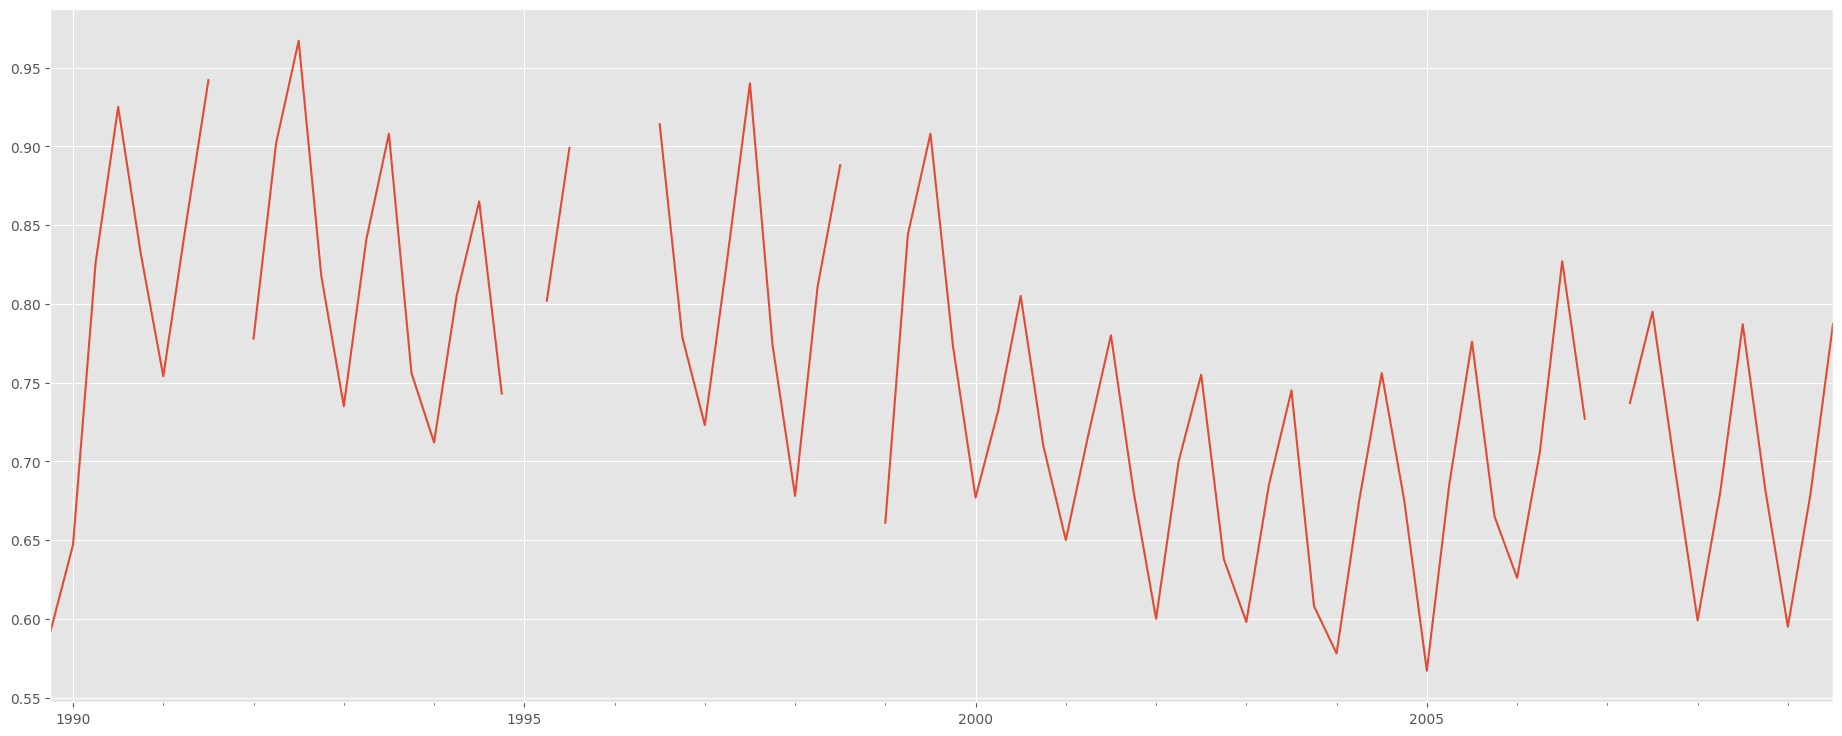

In [127]:
seasonal = macro.loc[:,'pop'].diff().dropna().tail(80).copy()

mask = np.random.binomial(1, 0.1, size=len(seasonal)) > 0 

seasonal_nan = seasonal.copy()
seasonal_nan[mask] = np.nan
seasonal_nan.plot()

previous = seasonal.shift(4)
future = seasonal.shift(-4)


# Усредним предудыщий и следующий периоды в аналогичном сезоне
seasonal_nan[seasonal_nan.isna()] = ((previous + future) / 2)[seasonal_nan.isna()]

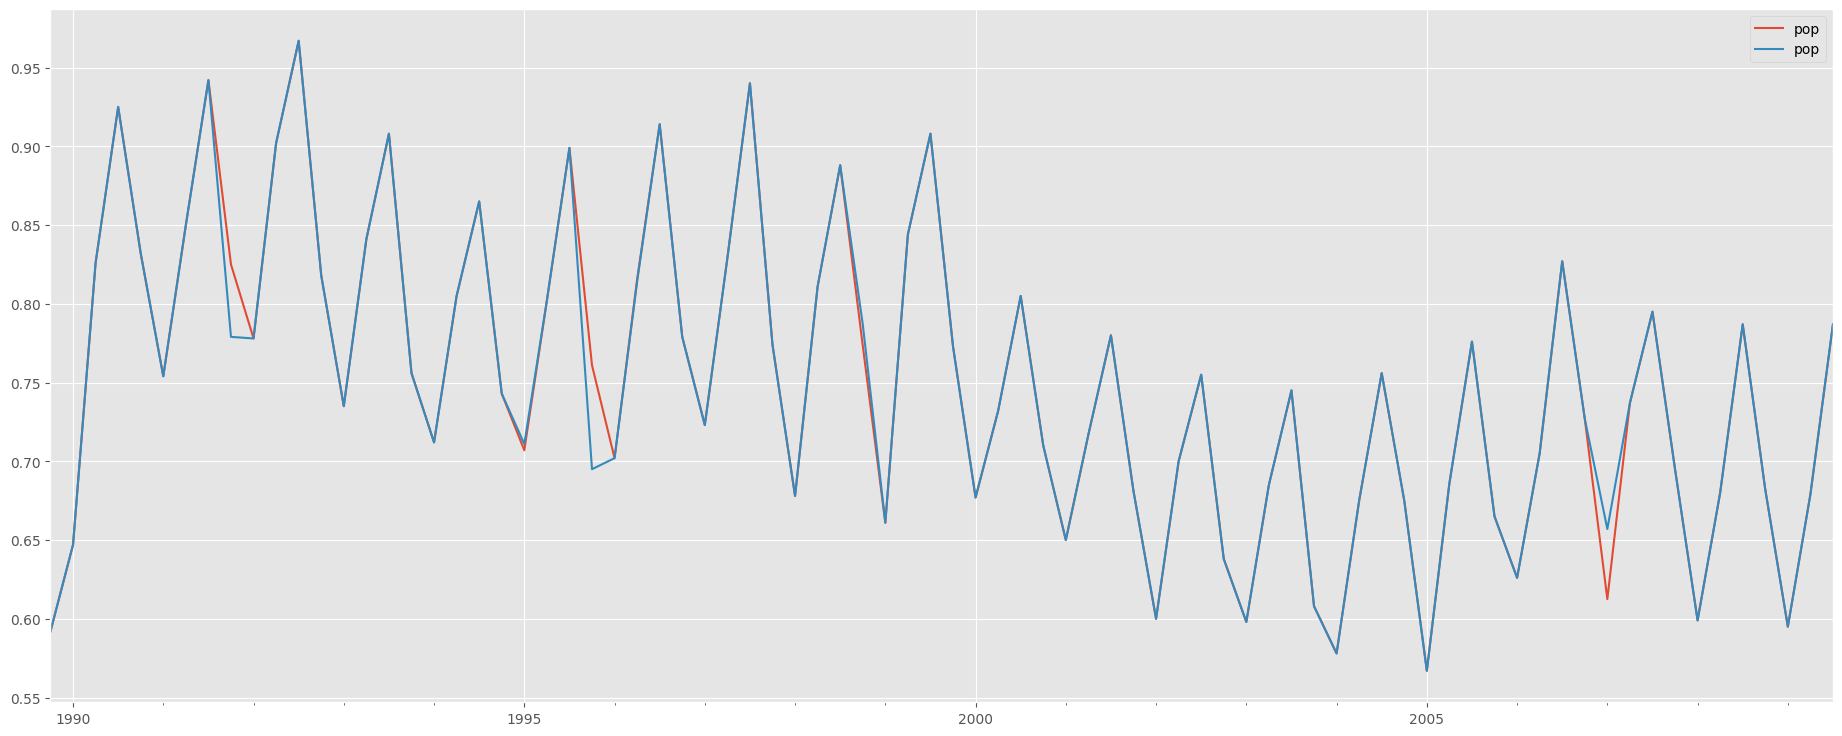

In [128]:
seasonal_nan.plot()
seasonal.plot()
plt.legend()

## Блок о том, почему наш курс не нужен

Первое о чём следует задуматься: а чем, собственно, ряды отличаются от стандартной задачи машинного обучений? Короткий ответ: особо ничем, но есть нюанс. В целом, задачу прогнозирования рядов можно решать как обычную табличную задачу. Сложность обычно в том, что под каждую задачу нужно отдельно возиться с генерацией признаков и порой простая модель временного ряда оказывается выразительнее кучи сгенерированныъ признаков. Сейчас мы попробуем повозиться немного с одной из таких задач. Данные взяты с [kaggle](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather?select=energy_dataset.csv). Будем прогнозировать потребление электроэнергии в Испании.

In [197]:
import pandas as pd
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_correlations
from sktime.forecasting.all import temporal_train_test_split
from sklearn.ensemble import RandomForestRegressor
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from catboost import  CatBoostRegressor

import numpy as np
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)



# Загрузим данные по энергетике
data = pd.read_csv('data/sem_2/energy_dataset.csv')

# # Преобразуем даты
data.index = pd.to_datetime(data.time.apply(lambda x: x.split('+')[0]))
data = data.drop(columns=['time'])


In [198]:
data

generation biomass  generation fossil brown coal/lignite  \
time                                                                            
2015-01-01 00:00:00               447.0                                 329.0   
2015-01-01 01:00:00               449.0                                 328.0   
2015-01-01 02:00:00               448.0                                 323.0   
2015-01-01 03:00:00               438.0                                 254.0   
2015-01-01 04:00:00               428.0                                 187.0   
...                                 ...                                   ...   
2018-12-31 19:00:00               297.0                                   0.0   
2018-12-31 20:00:00               296.0                                   0.0   
2018-12-31 21:00:00               292.0                                   0.0   
2018-12-31 22:00:00               293.0                                   0.0   
2018-12-31 23:00:00               290.0                                   0.0   

                     generation fossil coal-derived gas  \
time                                                      
2015-01-01 00:00:00                                 0.0   
2015-01-01 01:00:00                                 0.0   
2015-01-01 02:00:00                                 0.0   
2015-01-01 03:00:00                                 0.0   
2015-01-01 04:00:00                                 0.0   
...                                                 ...   
2018-12-31 19:00:00                                 0.0   
2018-12-31 20:00:00                                 0.0   
2018-12-31 21:00:00                                 0.0   
2018-12-31 22:00:00                                 0.0   
2018-12-31 23:00:00                                 0.0   

                     generation fossil gas  generation fossil hard coal  \
time                                                                      
2015-01-01 00:00:00                 4844.0                       4821.0   
2015-01-01 01:00:00                 5196.0                       4755.0   
2015-01-01 02:00:00                 4857.0                       4581.0   
2015-01-01 03:00:00                 4314.0                       4131.0   
2015-01-01 04:00:00                 4130.0                       3840.0   
...                                    ...                          ...   
2018-12-31 19:00:00                 7634.0                       2628.0   
2018-12-31 20:00:00                 7241.0                       2566.0   
2018-12-31 21:00:00                 7025.0                       2422.0   
2018-12-31 22:00:00                 6562.0                       2293.0   
2018-12-31 23:00:00                 6926.0                       2166.0   

                     generation fossil oil  generation fossil oil shale  \
time                                                                      
2015-01-01 00:00:00                  162.0                          0.0   
2015-01-01 01:00:00                  158.0                          0.0   
2015-01-01 02:00:00                  157.0                          0.0   
2015-01-01 03:00:00                  160.0                          0.0   
2015-01-01 04:00:00                  156.0                          0.0   
...                                    ...                          ...   
2018-12-31 19:00:00                  178.0                          0.0   
2018-12-31 20:00:00                  174.0                          0.0   
2018-12-31 21:00:00                  168.0                          0.0   
2018-12-31 22:00:00                  163.0                          0.0   
2018-12-31 23:00:00                  163.0                          0.0   

                     generation fossil peat  generation geothermal  \
time                                                                 
2015-01-01 00:00:00                     0.0                    0.0   
2015-01-01 01:00:00                  

In [199]:
# Загрузим данные по погоде
weather = pd.read_csv('data/sem_2/weather_features.csv')

# Преобразуем даты
weather.loc[:, 'dt_iso']= pd.to_datetime(weather.dt_iso.apply(lambda x: x.split('+')[0]))
weather = weather.loc[:, ['dt_iso', 'temp']]
# weather = weather.drop(columns=['dt_iso'])

# Усредним по регионам
weather = weather.groupby('dt_iso').mean()
weather.index.name = 'time'

weather

data = data.merge(weather.loc[:, ['temp']], how='left', left_on='time', right_on='time')

In [200]:
target = data.loc[:,'total load actual'].resample('D').sum()




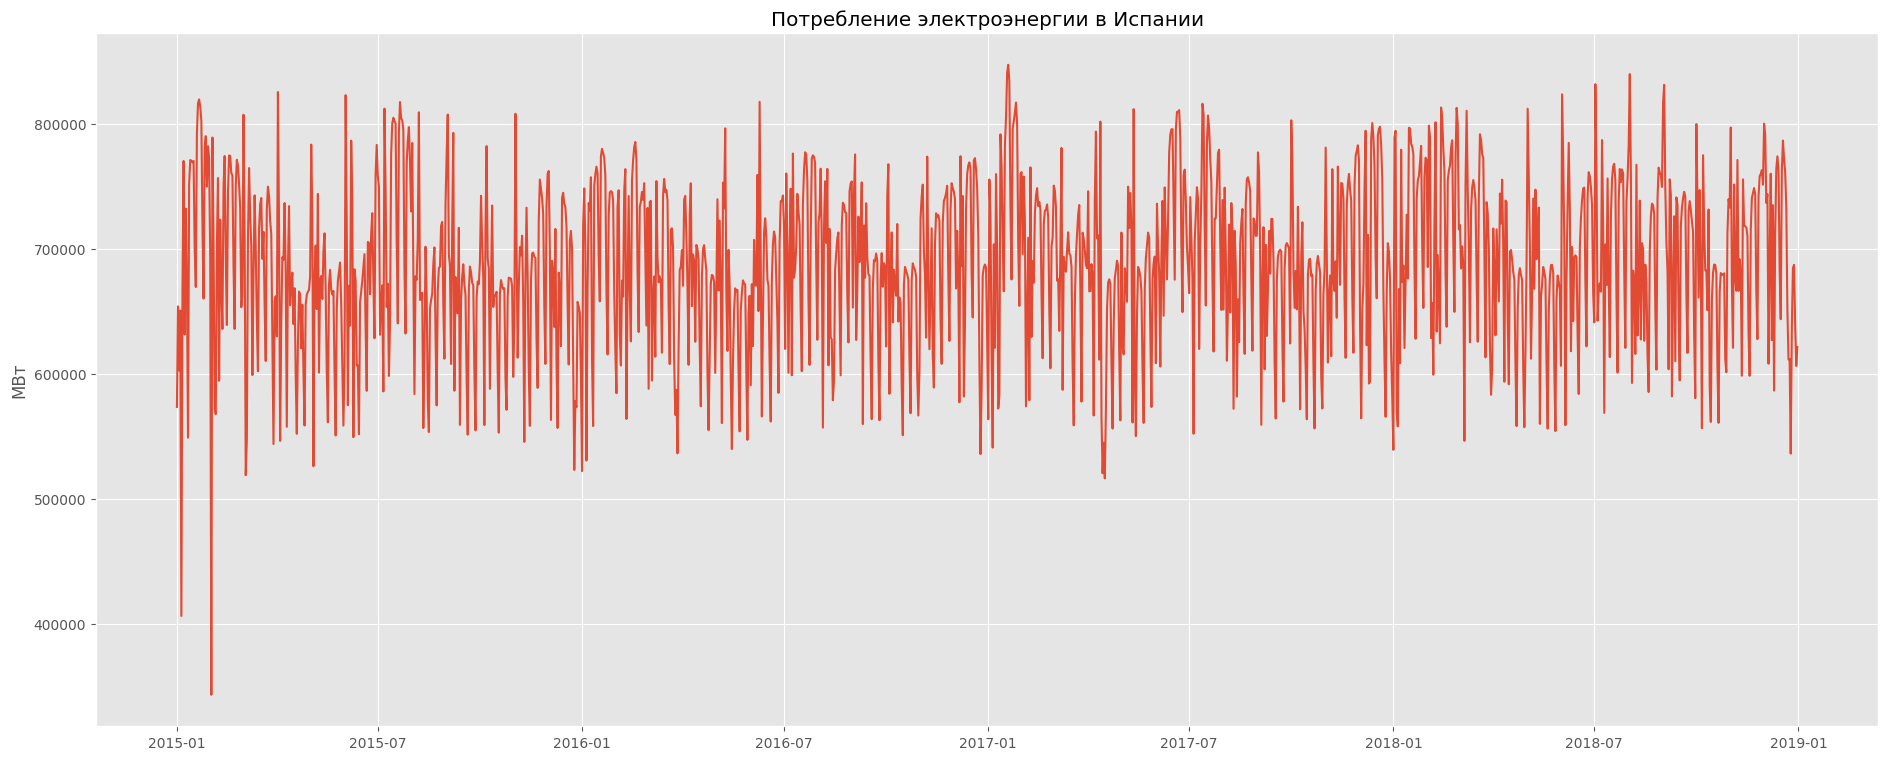

In [201]:
# Найти 
plt.plot(target)
plt.title('Потребление электроэнергии в Испании')
plt.ylabel('МВт');

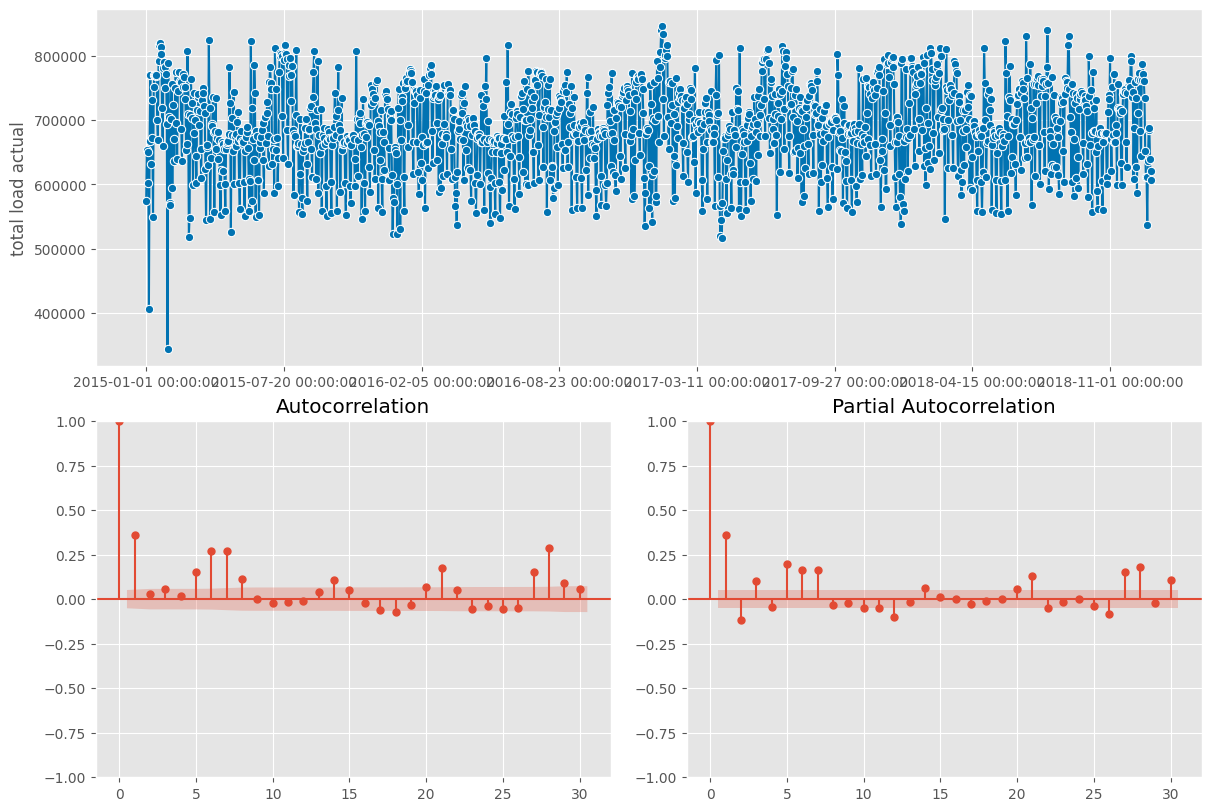

In [202]:
plot_correlations(target, lags=30);

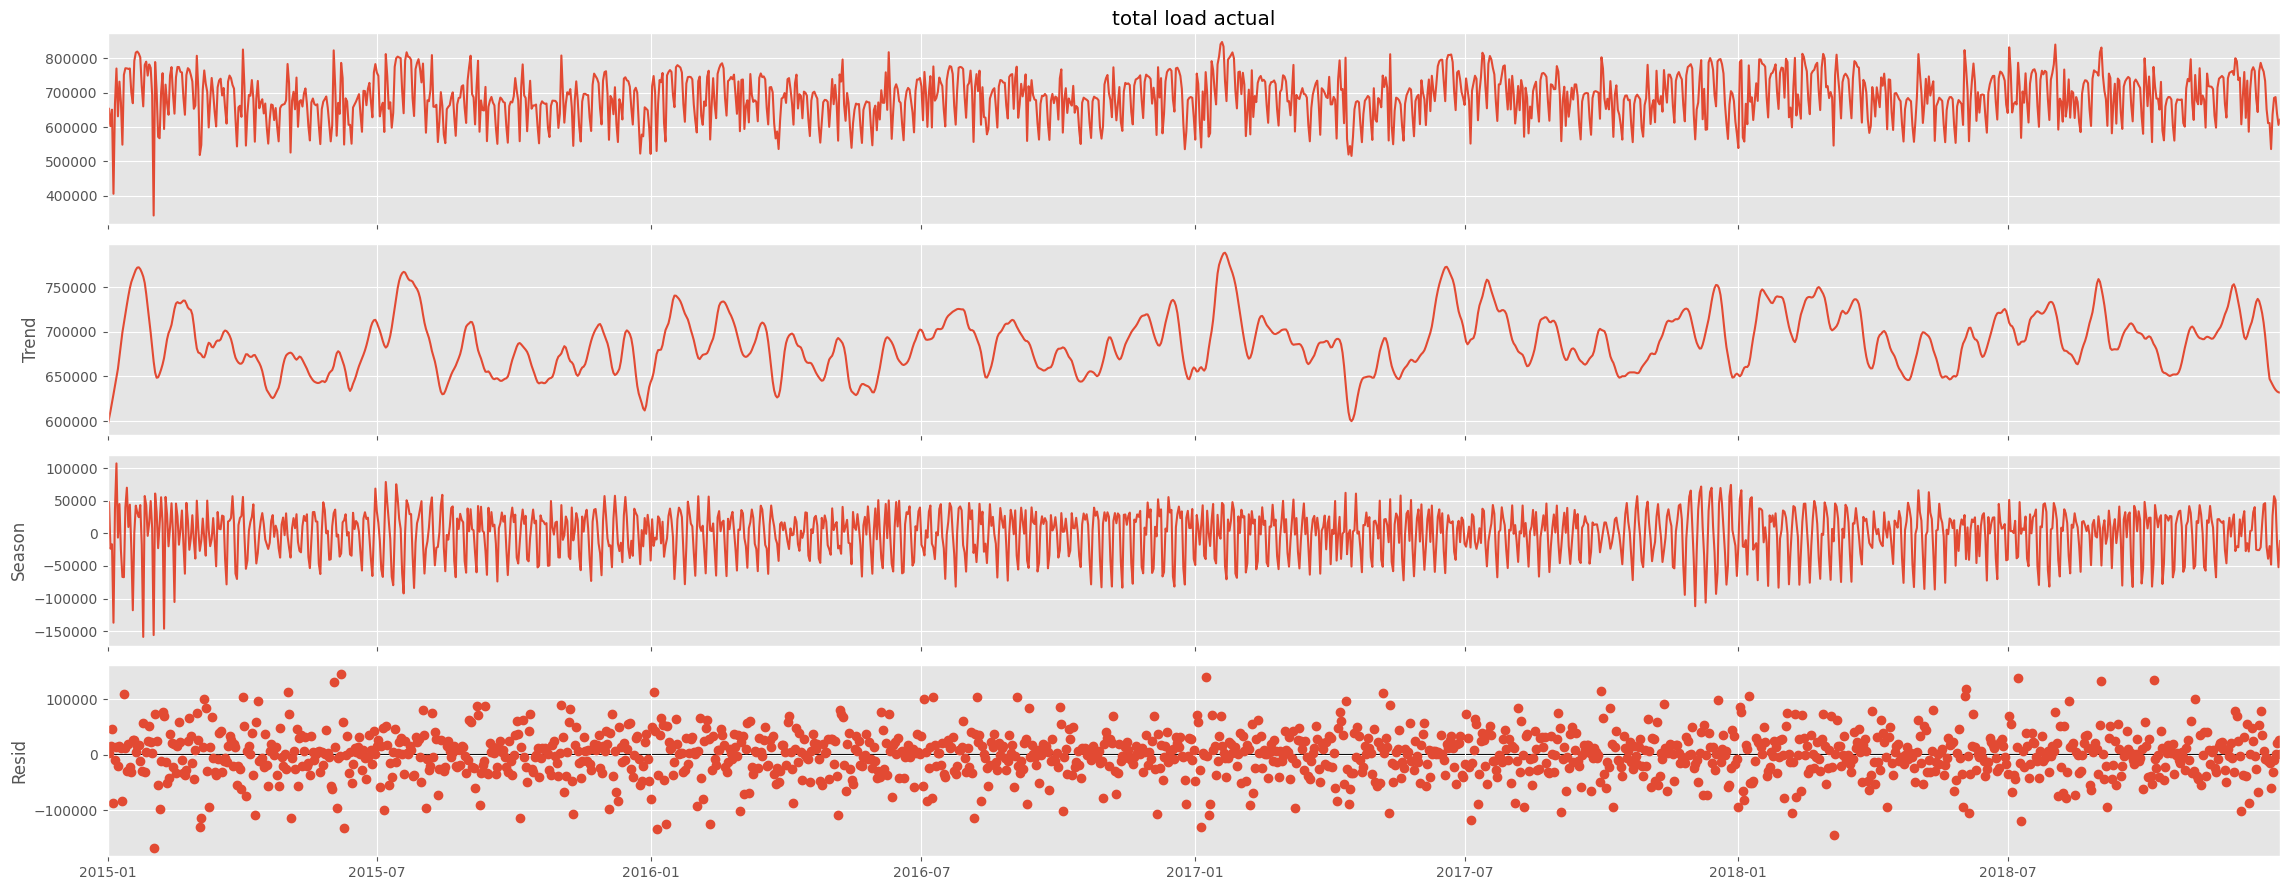

In [203]:
stl = STL(target, period=7)
res = stl.fit()
res.plot();


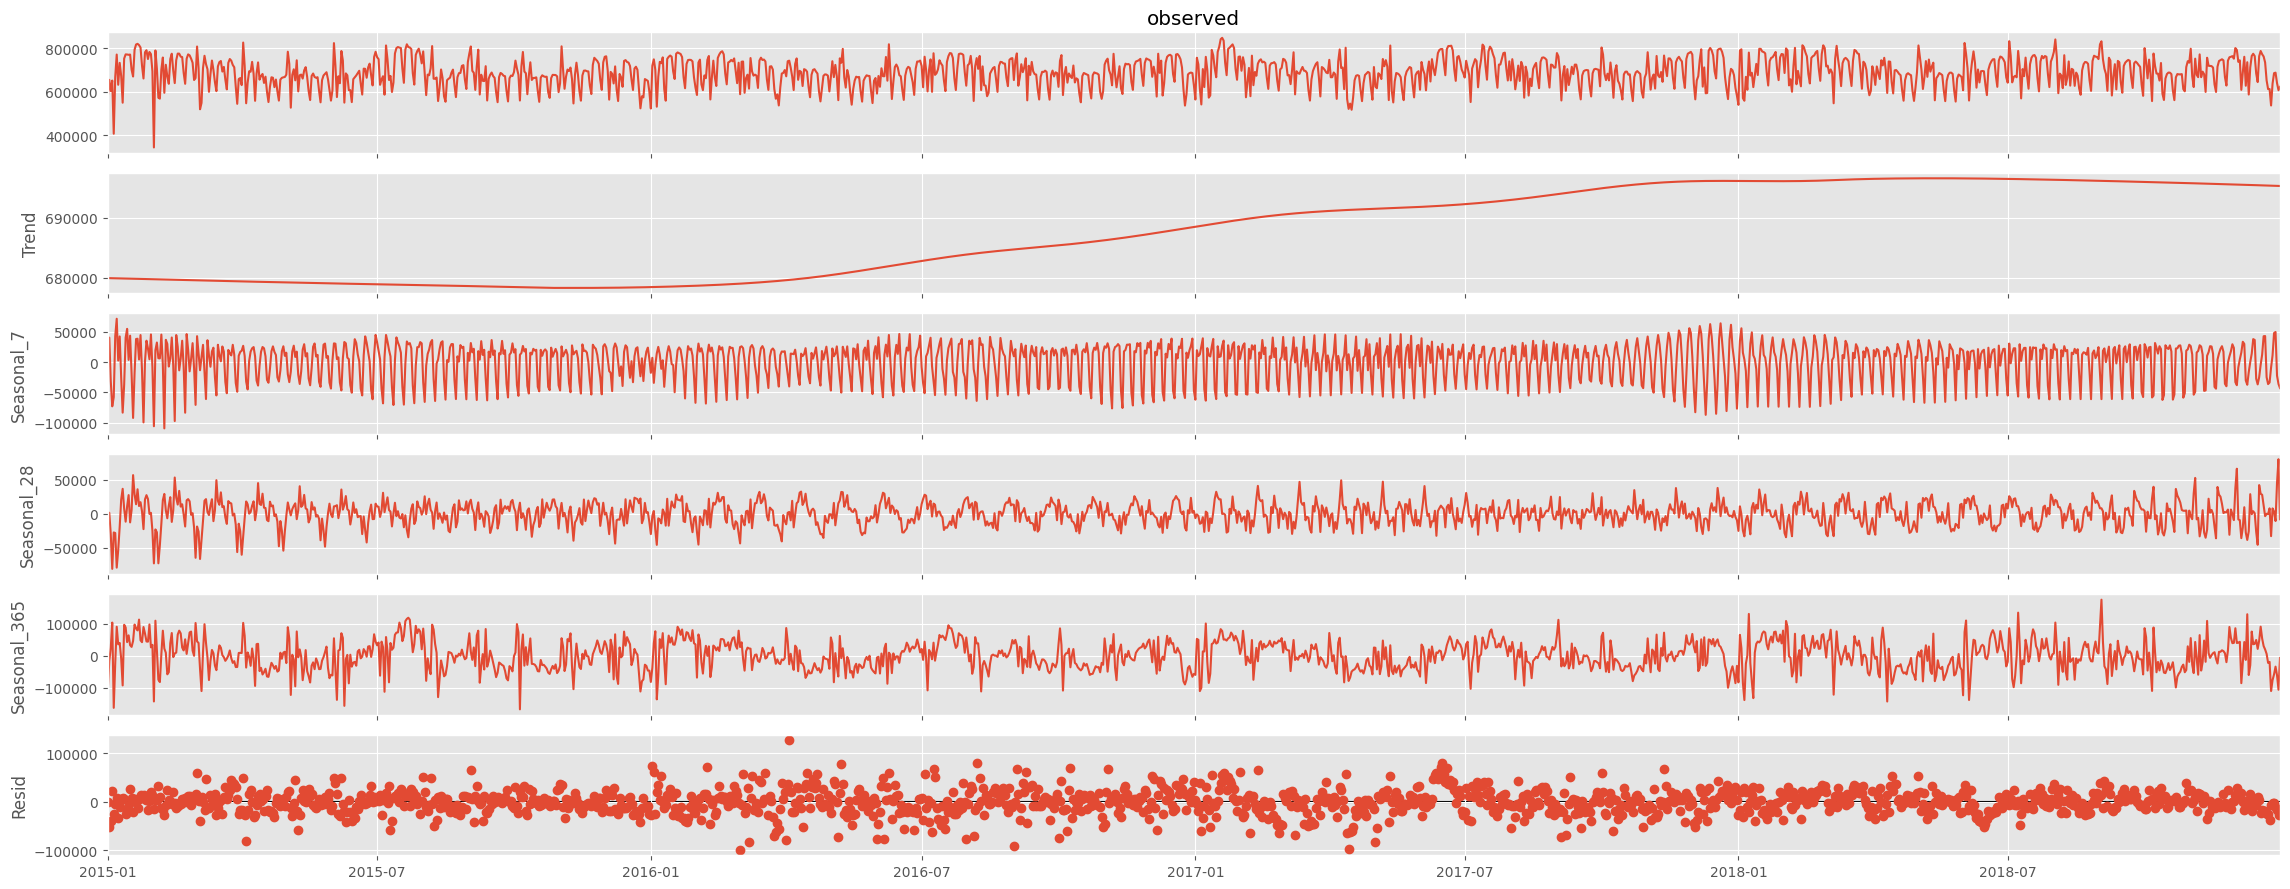

In [204]:
stl = MSTL(target, periods=[7, 28, 365])
res = stl.fit()
res.plot();

In [205]:
import holidays

es_holidays = holidays.Spain()

X = pd.DataFrame()

WINDOW = 10

X['target'] = data.loc[:,'total load actual'].resample('D').sum()

X['y_L1'] = X['target'].shift(1)
X['y_L2'] = X['target'].shift(2)
X['y_L3'] = X['target'].shift(3)
X['y_L4'] = X['target'].shift(4)

X['y_L6'] = X['target'].shift(6)
X['y_L7'] = X['target'].shift(7)
X['y_L31'] = X['target'].shift(31)

X['y_L364'] = X['target'].shift(364)
X['y_L365'] = X['target'].shift(365)
X['y_L366'] = X['target'].shift(366)


X['diff_L1'] = X['target'].diff().shift(1)

# X['rolling_mean'] = X['target'].rolling(WINDOW).mean().shift(1)


# X['month'] = X.index.month
X['day'] = X.index.day
X['weekday'] = X.index.weekday
X['is_weekend'] = X.index.weekday >= 5
X['season'] = X.index.month%12 // 3 + 1


X['temp'] = data.loc[:,'temp'].resample('D').min() * (X.season == 1) \
        + data.loc[:,'temp'].resample('D').max() * (X.season == 3) \
        + data.loc[:,'temp'].resample('D').mean() * ((X.season == 2) | (X.season == 4))

# X['temp'] = X['temp'].shift(365)

# X['cos'] = np.cos((X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))

t = (X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
X['sin'] = np.sin(t)


X['is_holiday'] = X.index.to_series().apply(lambda x: x in es_holidays)

In [206]:
X = X.dropna()

y = X.target
X = X.drop(columns=['target', "season"])

In [182]:
X

y_L1      y_L2      y_L3      y_L4      y_L6      y_L7  \
time                                                                     
2016-01-02  522125.0  600159.0  648988.0  653713.0  573243.0  578302.0   
2016-01-03  719136.0  522125.0  600159.0  648988.0  657641.0  573243.0   
2016-01-04  748524.0  719136.0  522125.0  600159.0  653713.0  657641.0   
2016-01-05  700822.0  748524.0  719136.0  522125.0  648988.0  653713.0   
2016-01-06  530521.0  700822.0  748524.0  719136.0  600159.0  648988.0   
...              ...       ...       ...       ...       ...       ...   
2018-12-27  636691.0  536106.0  611884.0  611552.0  734264.0  761545.0   
2018-12-28  684773.0  636691.0  536106.0  611884.0  651730.0  734264.0   
2018-12-29  687306.0  684773.0  636691.0  536106.0  611552.0  651730.0   
2018-12-30  639282.0  687306.0  684773.0  636691.0  611884.0  611552.0   
2018-12-31  606334.0  639282.0  687306.0  684773.0  536106.0  611884.0   

               y_L31    y_L364    y_L365    y_L366   diff_L1  day  weekday  \
time                                                                         
2016-01-02  762505.0  602656.0  654031.0  573522.0  -78034.0    2        5   
2016-01-03  698044.0  650703.0  602656.0  654031.0  197011.0    3        6   
2016-01-04  563041.0  406070.0  650703.0  602656.0   29388.0    4        0   
2016-01-05  690610.0  667264.0  406070.0  650703.0  -47702.0    5        1   
2016-01-06  681980.0  770520.0  667264.0  406070.0 -170301.0    6        2   
...              ...       ...       ...       ...       ...  ...      ...   
2018-12-27  742193.0  697878.0  704641.0  665937.0  100585.0   27        3   
2018-12-28  758041.0  676115.0  697878.0  704641.0   48082.0   28        4   
2018-12-29  760195.0  616537.0  676115.0  697878.0    2533.0   29        5   
2018-12-30  763215.0  580885.0  616537.0  676115.0  -48024.0   30        6   
2018-12-31  751533.0  539088.0  580885.0  616537.0  -32948.0   31        0   

            is_weekend        temp       sin  is_holiday  
time                                                      
2016-01-02        True  281.784000 -0.181736       False  
2016-01-03        True  281.644000 -0.260858       False  
2016-01-04       False  284.070000 -0.338262       False  
2016-01-05       False  280.524500 -0.413440       False  
2016-01-06       False  278.600900 -0.485896        True  
...                ...         ...       ...         ...  
2018-12-27       False  277.454000 -0.629956       False  
2018-12-28       False  277.512000 -0.690844       False  
2018-12-29        True  277.722000 -0.747183       False  
2018-12-30        True  275.288333 -0.798605       False  
2018-12-31       False  274.908000 -0.844768       False  

[1095 rows x 17 columns]

In [183]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

scaler = MinMaxScaler()
cat_features = [
    # 'month',
    'day',
    'weekday',
    'is_weekend',
    'is_holiday',
    # 'season'
    ]

num_features = [col for col in X_train.columns if col not in cat_features]

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


In [184]:


model = CatBoostRegressor(iterations=50, 
                          depth=2, 
                          learning_rate=0.5)

model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
y_pred = pd.Series(model.predict(X_test), index=y_test.index)
mean_absolute_percentage_error(y_test, y_pred)


0.04802690841448866

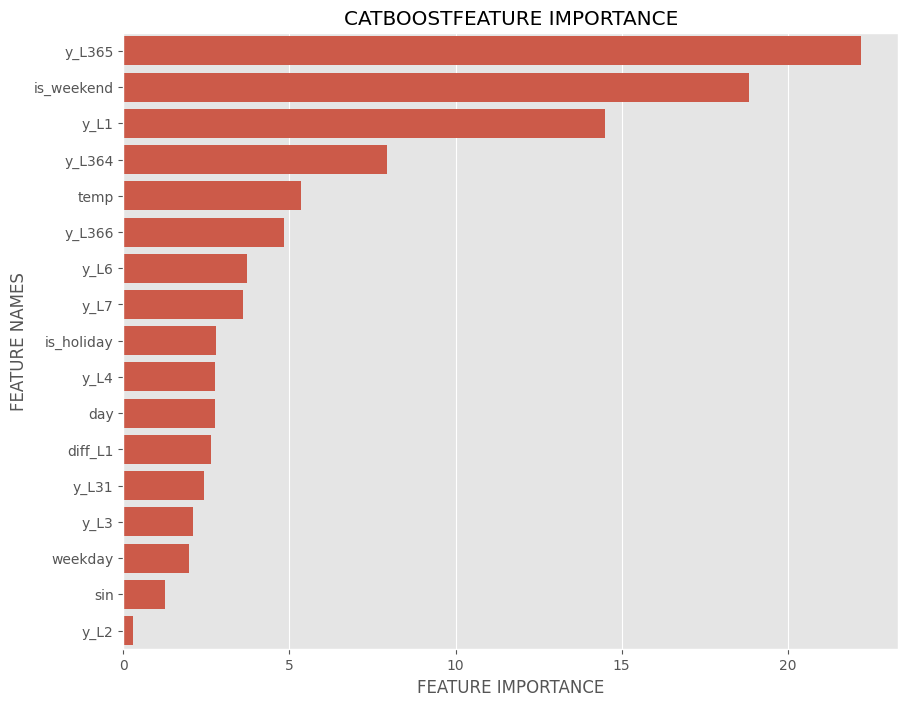

In [185]:
import seaborn as sns
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(),X.columns,'CATBOOST')

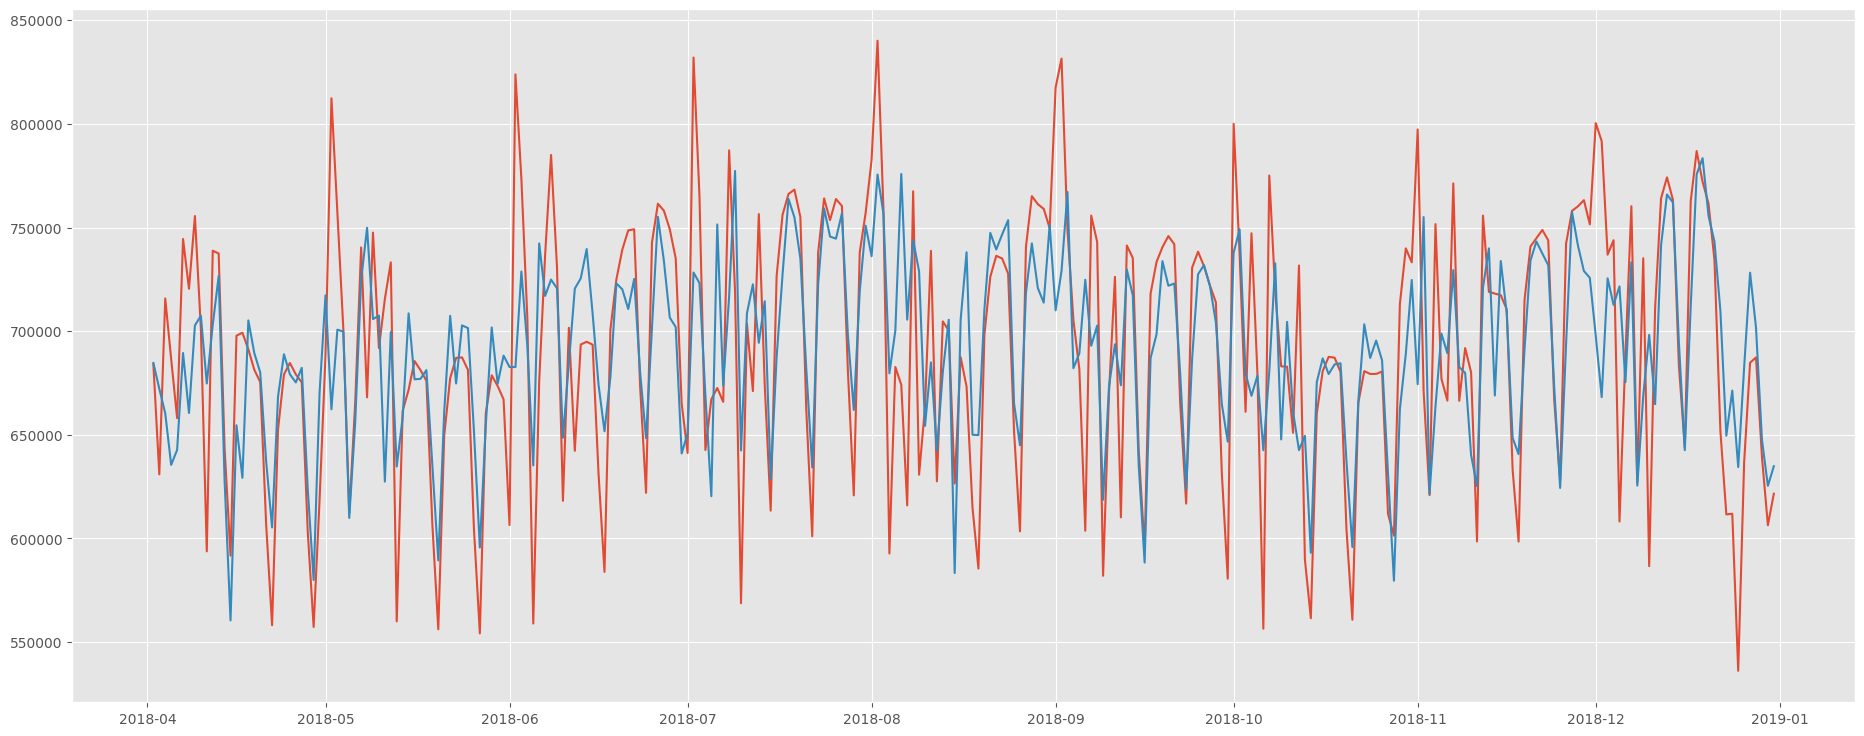

In [186]:
plt.plot(y.tail(len(y_pred)))
plt.plot(y_pred)

In [188]:
mean_absolute_percentage_error(y_test, y_pred)

# mean_absolute_percentage_error(y_test, y.tail(len(y_pred)).shift(1).fillna(0))


0.04802690841448866

## Стратегии многошагового прогнозирования

В предыдущем пункте, казалось бы, всё было хорошо. Мы научились прогнозировать с некоторой относительно неплохой точностью временной ряд. Однако есть одна загвоздка. Мы научились прогнозировать только на один шаг. А хотелось бы, конечно, на много шагов. Именно многошаговое прогнозирование является основной задачей при работе с временными рядами (хотя, конечно, и не всегда). 

Для построения многошаговых прогнозов необходима, как и в одношаговом случае, оценить некоторую модель, а потом с помощью специальной методики (стратегии) применить её для прогнозирования. Мы рассмотрим две основные существующие стратегии: рекурсивная (recursive) и прямая (direct).

## Рекурсивная стратегия

Давайте представим, что нам необходимо спрогнозировать какой-то временной ряд на 5 шагов вперёд. Точку, из которой мы строим прогноз, обычно называют forecast origin, а то, на сколько шагов мы прогнозируем -- горизонт прогнозирования (forecast horizon). Пусть также у нас предполагается самая простая модель:

$$ y_t = \beta_0 + \beta_1 y_{t-1}+ \epsilon_t$$

Как только мы найдём любым доступным способом $\hat{\beta}_0 $ и $\hat{\beta}_1$, то сможем построить прогноз на один шаг вперёд:

$$ \hat{y}_{t+1} = \hat{\beta}_0 + \hat{\beta}_1 y_{t}$$

На один шаг мы построили. Теперь давайте подумаем про второй. Хотелось бы, конечно, построить следующее уравнение:

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 y_{t+1}$$

Однако $y_{t+1}$ мы не знаем. Однако знаем оценку, $\hat{y}_{t+1}$. Ну значит давайте и подставим её, чтобы всё работало. Таким образом прогноз на два шага будет основываться на прогнозе на один шаг:

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+1}$$

Эту стратегию использую чаще всего. Более того, большая часть статистических моделей, которые мы будем проходить впоследствии, просто технически не могут реализовать какую-то другую. Однако она не лишена недостатков. Один из основных -- накопление ошибки при рекурсивных прогнозах. С каждым шагом ошибка предыдущего шага порождает ещё большу ошибку на последующих. Особенно сильно такой эффект наблюдается, когда модель имеет авторегрессию большего порядка. Значит, что в каждом последующем прогнозе будет учитываться оценка не только предыдущего момента времени, но и оценки всех значений, входящих в уравнение. Например:

$$ \hat{y}_{t+3} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+2} + \hat{\beta}_2 \hat{y}_{t+1} + \hat{\beta}_2 y_{t}$$

Помимо этого существует ещё одна существенная проблема. Давайте снова представим простую модель, но уже с экзогенной переменной $x_t$:

$$ y_t = \beta_0 + \beta_1 y_{t-1} + \gamma_1 x_{t-1} \epsilon_t$$

$$ \hat{y}_{t+1} = \hat{\beta}_0 + \hat{\beta}_1 y_{t} + + \hat{\gamma}_1 x_{t} $$

При одношаговом прогнозе в целом никаких проблем не возникает. Однако на втором шаге уже проблемы: 

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+1} + \hat{\gamma}_1 x_{t+1} $$

$x_{t+1}$ нам взять неоткуда. Следовательно, у нас два варианта. Либо прогнозировать отдельно ряд $x_t$, что добавит ещё больше шума в модель, либо не использовать этот регрессор вообще и полагаться только на фичи, которые либо основаны на $y_t$ (тоже добавит шума), либо могут быть сгенерированы независимо (например, календарные фичи). На самом деле часто бывают задачи, в которых экзогенных переменных нет вовсе и такая проблема не стоит, но всё же это достаточно редкий случай. 

Наши данные из-за большого количества экзогенных и производных переменных не подойдут под рекурсивную стратегию, поэтому приведём здесь пример на более игрушечных данных.

In [194]:
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.compose import make_reduction

# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sklearn.linear_model import LinearRegression



0.1545084046730804

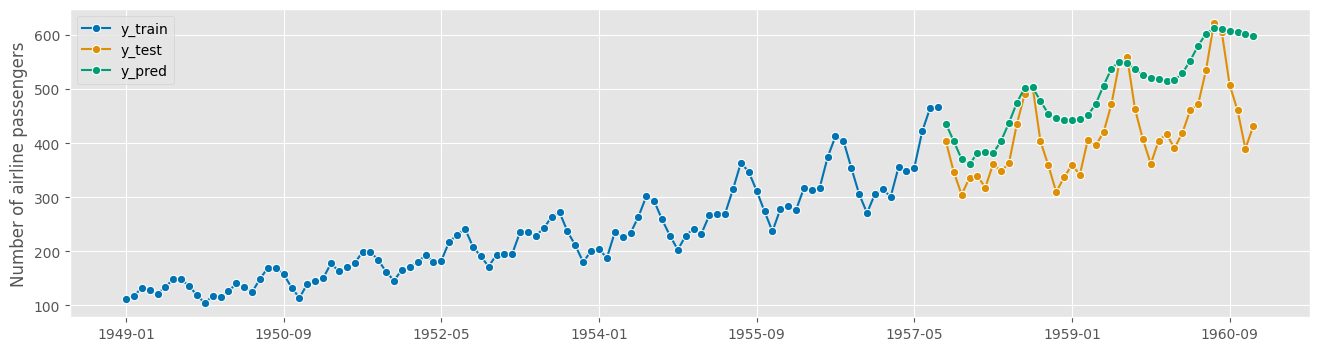

In [195]:
# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=40)
fh = ForecastingHorizon(y_test.index, is_relative=False)
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=10, strategy="recursive")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

## Прямая стратегия

Внимательный слушатель резонно задастся вопросом: А зачем, собственно, предсказывать все горизонты одной моделью. И правда, да ничего не мешает. Пусть нам нужно прогнозировать на h шагов. Тогда оценим h моделей вида:

$$ \hat{y}_{t+1} = \hat{\beta}_0^1 + \hat{\beta}_1^1 y_{t}$$

$$ \hat{y}_{t+2} = \hat{\beta}_0^2 + \hat{\beta}_1^2 y_{t}$$

$$ \hat{y}_{t+3} = \hat{\beta}_0^3 + \hat{\beta}_1^3 y_{t}$$

$$ \cdots $$

$$ \hat{y}_{t+k} = \hat{\beta}_0^k + \hat{\beta}_1^k y_{t}$$

Недостатки такого подхода:
* Вместо одной модели нужно оценивать h. Это очень сильно увеличивает вычислительные затраты, особенно при кросс-валидации.
* Растёт общий разброс модели, так как оцениваем в h раз больше параметров.

Преимущества такого подхода:
* Очевидно, меньше смещение. Ошибки предыдущих горизонтов не влияют на проноз по текущему.
* Более явная модель для многошагового прогноза. Можно, например, подобрать одни переменные, важные для прогноза на длинный период и друге для короткого. 
* Обычно высокий разброс не так критичен как смещение рекурсивной стратегии и в моей практике я стараюсь использовать прямую стратегию.
* Никаких проблем с экзогенными и производными переменными.
* Часто очень неплохо работает вкупе с обычной линейной регрессией и при грамотно сгенерированных фичах

0.04061570008131549

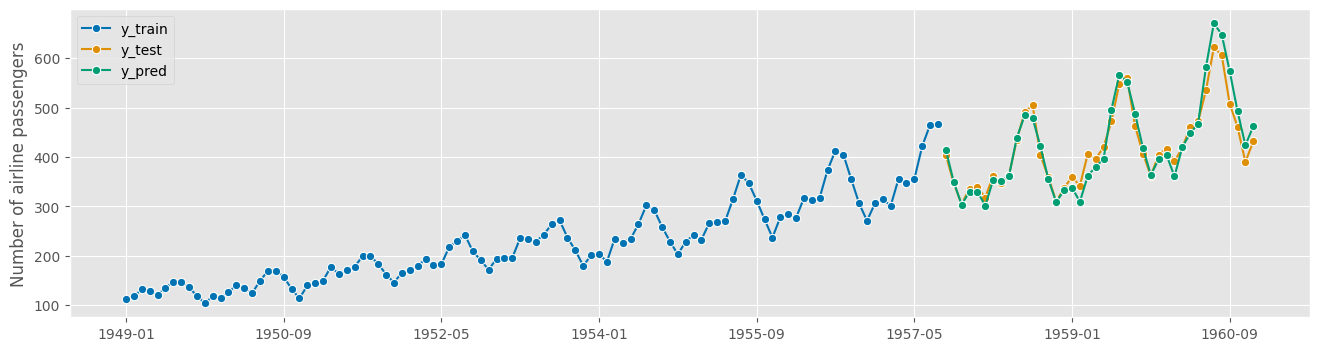

In [196]:
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=10, strategy="direct")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

0.0657277933186012

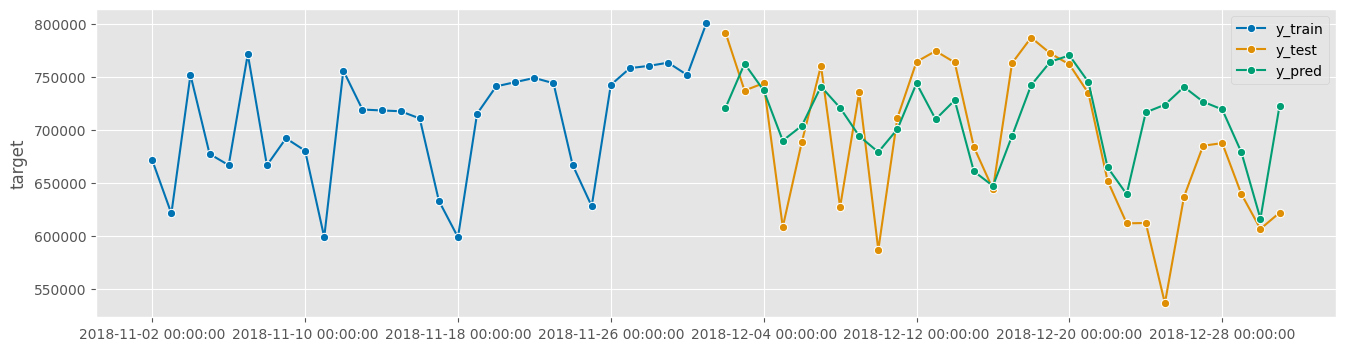

In [211]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=30)

scaler = MinMaxScaler()
cat_features = [
    # 'month',
    'day',
    'weekday',
    'is_weekend',
    'is_holiday',
    # 'season'
    ]
num_features = [col for col in X_train.columns if col not in cat_features]

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

fh = ForecastingHorizon(y_test.index, is_relative=False)

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=20, strategy="direct")

forecaster.fit(y_train, X=X_train, fh=fh);
y_pred = forecaster.predict(X=X_train)
plot_series(y_train.tail(30), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [213]:
mape = MeanAbsolutePercentageError(symmetric=False)

mape(y_test, y_pred)

0.07218270735741338

## Бенчмарки

In [214]:

# step 1: splitting historical data
# y = load_airline()
# y_train, y_test = temporal_train_test_split(y, test_size=36)

# step 2: running the basic forecasting workflow
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# if function interface is used, just use the function directly in step 4


# step 4: computing the forecast performance
mape(y_test, y_pred)

# step 5: testing forecast performance against baseline
# under development

0.11524182452059722